# HW4

Overall rules:

- Do not split your answers into separate files. All answers must be in a single jupyter notebook.
- Obtain all required remote data using the appropriate API unless otherwise is specified.
- Refrain from using code comments to explain what has been done. Document your steps by writing appropriate markdown cells in your notebook.
- Avoid duplicating code by copying and pasting it from one cell to another. If copying and pasting is necessary, develop a suitable function for the task at hand and call that function.
- When providing parameters to a function, never use global variables. Instead, always pass parameters explicitly and always make use of local variables.
- Document your use of LLM models (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW4-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 15-point deduction for each infraction.

In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import time

## Q1

In this problem, you will compare the performance of several supervised learning models on the CIFAR-10 dataset available through `tensorflow_datasets`. The CIFAR-10 dataset consists of 60,000 $32 \times 32$ color images in 10 classes, with 6,000 images per class. To simplify the computational requirements and focus on core algorithmic aspects, you may preprocess the images by converting them to grayscale.

1. Load the CIFAR-10 dataset using the `tensorflow_datasets` library. Preprocess the dataset by:
   - Converting the images to grayscale,
   - Flattening the image into a vector (if necessary) for models that require vector inputs,
   - Normalizing pixel values to the $[0,1]$ range.

2. Train and evaluate the following models on the dataset:
   - **Logistic Regression** (one-vs-rest and one-vs-one),
   - **Support Vector Machine (SVM)** with:
     - A linear kernel,
     - A Gaussian (RBF) kernel,
     - A polynomial kernel,
   - **A simple neural network** consisting of:
     - One or two hidden layers,
     - Nonlinear activation functions (such as ReLU or tanh),
     - A softmax output layer for classification.

3. For each model, report:
   - The overall test set classification accuracy,
   - The confusion matrix,
   - Precision, recall, and F1-score per class.

4. Conduct a **statistical error analysis**:
   - Compute $95\%$ confidence intervals for the test set accuracy estimates (e.g., using the binomial proportion confidence interval),
   - Discuss any significant differences between model performances.

5. Discuss the **computational trade-offs**:
   - Measure and report the **training time** and **inference time** for each model (e.g., using simple timing functions),
   - Measure and report **memory usage** where feasible (e.g., by estimating the number of parameters or using profiling tools),
   - Reflect on how model complexity (both in terms of runtime and memory) correlates with performance.

6. Conclude by discussing the observed trade-offs between **model simplicity**, **computational cost**, and **predictive accuracy**.

You may use `tensorflow`, `pytorch` or `keras` for neural network model implementation. Clearly indicate any hyperparameter choices (e.g., regularization strength, kernel parameters, number of neurons in hidden layers). Ensure that your experimental code supports reproducibility (by fixing random seeds where applicable).


In [ ]:
def load_cifar10():
    dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True)
    train_data = dataset['train']
    test_data = dataset['test']
    return train_data, test_data


def preprocess_data(dataset):
    def preprocess_image(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.cast(image, tf.float32) / 255.0
        image = tf.reshape(image, (-1,))
        return image, label

    dataset = dataset.map(preprocess_image)
    return dataset


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

train_data, test_data = load_cifar10()
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)


def dataset_to_numpy(dataset):
    images, labels = [], []
    for image, label in dataset:
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

X_train, y_train = dataset_to_numpy(train_data)
X_test, y_test = dataset_to_numpy(test_data)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



lda = LDA(n_components=None)
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.RLXEE1_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.RLXEE1_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


Cifar10 verisini çekip veriyi gri renge döndürdük sonra tek boyutlu vektörlere dönüstürdük ve scale ettikten sonra lda algoritması ile verinin boyutunu düşülttük ki (lda ile bunu sınıf ayrımını maksimuum yapabilecek sekilde hallettik)

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

def evaluate_model(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    return accuracy, cm, precision, recall, fscore

def binomial_confidence_interval(accuracy, n, confidence=0.95):
    z = 1.96
    p = accuracy
    ci = z * np.sqrt((p * (1 - p)) / n)
    return (p - ci, p + ci)

def measure_time_and_memory(model, X_train, X_test, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    start_time = time.time()
    model.predict(X_test)
    inference_time = time.time() - start_time

    try:
        num_params = sum(np.prod(v.get_shape().as_list()) for v in model.trainable_variables)
    except:
        num_params = "N/A"

    return training_time, inference_time, num_params


Moddellerde ölçeceğimiz analiz edeceğimiz konuların metodunu yazdık

In [ ]:
def run_model_analysis(name, model, X_train, X_test, y_train, y_test):
    print(f"\n=== {name} ===")


    model_clone = clone(model)


    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    acc, cm, precision, recall, fscore = evaluate_model(y_test, y_pred)
    ci = binomial_confidence_interval(acc, len(y_test))


    train_time, inf_time, num_params = measure_time_and_memory(model_clone, X_train, X_test, y_train)


    cv_scores = cross_val_score(model_clone, X_train, y_train, cv=5)


    print(f"Accuracy: {acc:.4f}")
    print(f"95% Confidence Interval: {ci}")
    print(f"Training Time: {train_time:.2f}s, Inference Time: {inf_time:.2f}s")
    print(f"Trainable Parameters: {num_params}")
    print(f"Cross-Val Score Mean: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")
    print("Confusion Matrix:\n", cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", fscore)


In [ ]:
from sklearn.utils import resample

def downsample_data(X, y, sample_size=10000, random_state=42):

    data = list(zip(X, y))
    data_downsampled = resample(data, n_samples=sample_size, random_state=random_state)
    X_down, y_down = zip(*data_downsampled)
    return np.array(X_down), np.array(y_down)


Veri sayımız hala çok çok fazla ve muhtemelen LR(OvR) dısında modellerimiz çalısmayacak ya da cok uzun sürecek bu sebeple downsample etmliyiz.

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
logreg_ovr = LogisticRegression(max_iter=1000, multi_class='ovr')
run_model_analysis("Logistic Regression (OvR)", logreg_ovr, X_train, X_test, y_train, y_test)


X_train_small, y_train_small = downsample_data(X_train, y_train, sample_size=10000)
X_test_small, y_test_small = downsample_data(X_test, y_test, sample_size=2000)

logreg = LogisticRegression(max_iter=1000)
logreg_ovo = OneVsOneClassifier(logreg)
run_model_analysis("Logistic Regression (OvO)", logreg_ovo, X_train_small, X_test_small, y_train_small, y_test_small)


svm_linear = SVC(kernel='linear')
run_model_analysis("SVM (Linear)", svm_linear, X_train_small, X_test_small, y_train_small, y_test_small)


svm_rbf = SVC(kernel='rbf')
run_model_analysis("SVM (RBF)", svm_rbf, X_train_small, X_test_small, y_train_small, y_test_small)

svm_poly = SVC(kernel='poly')
run_model_analysis("SVM (Polynomial)", svm_poly, X_train_small, X_test_small, y_train_small, y_test_small)



=== Logistic Regression (OvR) ===


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Accuracy: 0.2700
95% Confidence Interval: (np.float64(0.2612983946308742), np.float64(0.27870160536912586))
Training Time: 1.05s, Inference Time: 0.01s
Trainable Parameters: N/A
Cross-Val Score Mean: 0.3455, Std: 0.0059
Confusion Matrix:
 [[300  52  83  47  62  66  54  90 169  77]
 [ 52 329  32  48  40  26  94  68 102 209]
 [132  45 179 111 119  86 118  92  83  35]
 [ 81  62  97 155  91 161 131  87  67  68]
 [ 85  49 122  82 165 111 148 130  60  48]
 [ 84  40 102  95  95 282  98  77  78  49]
 [ 64  96  90 118  93  97 239  72  64  67]
 [ 62  58 107  63 110  79  82 254  91  94]
 [115 102  31  44  16  76  42  57 381 136]
 [ 40 197  30  23  39  23  49  62 121 416]]
Precision: [0.2955665  0.31941748 0.20504009 0.19720102 0.19879518 0.28003972
 0.22654028 0.25682508 0.31332237 0.3469558 ]
Recall: [0.3   0.329 0.179 0.155 0.165 0.282 0.239 0.254 0.381 0.416]
F1-Score: [0.29776675 0.32413793 0.19113721 0.17357223 0.18032787 0.28101644
 0.23260341 0.25540473 0.34386282 0.3783538 ]

=== Logistic

Sonucları tek tek incelediğimizde modellerin accuracyleri çok düsük geldi ve cv scorelara baktığımızda modeller tutarlı yapıya sahip. Bunun sebebi çok fazla sınıf olması ve sınıf yapısının birbirine benzemesi f1 ve precision sonuclarına baktıgımızda 1 ve 8. sınıf 0.36-0.41 arası yani daha belirgin özellikleri var, ama 3 ve 6. sınıf arası bu değerlerin çok düsşük olması sınıfların birbirine cok benzediiğinin ve modellerin accuracysinin neden çok düsük olduğunun da kanıtı.
Çıktılarda train süresine baktığımızda en hızlı modelin LR(OvR) oldugunu görüyoruz dümdüz train edilmesinden dolayı memory kullanımı da daha az , SVM modellerine baktığımda bütün verileri support vektör haline döndğrdüğünden dolayı daha karmasık bi train süreci ve yavaslar özellikle memoryde bu vectore dönüstürme işleminden dolayı yer kaplıyorlar, polynomial kernel özellikle büyük dereceler için memory i çok zorlayabilir ve overfit olmaya da yakın bir model oldugu için riskli bir model. Svm (Rbf) doğruluk ve memory kullanımı acısından karsılastırdığım modellere göre bu veri seti için daha iyi bir model çünkü non linear ve düzenli ayrılan modellerde daha esnek bir biçimde sınıflandırır. Bu sebeple polynomiala göre daha iyi ayırmıs, train süresi de daha kısa ama inference yani karar süresi daha uzun sürmüş çünkü daha esnek olduğu için karar verme sırasında o esneklikten dolayı süre azıcık daha uzun olur.

In [ ]:
!pip install scikeras


In [ ]:
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    fscore = f1_score(y_true, y_pred, average=None)

    accuracy = accuracy_score(y_true, y_pred)

    return accuracy, cm, precision, recall, fscore

def binomial_confidence_interval(acc, n):
    from statsmodels.stats.proportion import proportion_confint
    ci_low, ci_high = proportion_confint(acc * n, n, alpha=0.05, method='wilson')
    return (np.float64(ci_low), np.float64(ci_high))


def run_nn_analysis(model, X_train, X_test, y_train, y_test):
    print("\n=== Neural Network ===")

    start_time = time.time()
    model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=0)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    inf_time = time.time() - start_time

    acc, cm, precision, recall, fscore = evaluate_model(y_test, y_pred)
    ci = binomial_confidence_interval(acc, len(y_test))
    num_params = model.count_params()


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        model_temp = build_model()
        model_temp.fit(X_train[train_idx], y_train[train_idx], epochs=5, batch_size=64, verbose=0)
        y_pred_cv = np.argmax(model_temp.predict(X_train[val_idx]), axis=1)
        cv_scores.append(accuracy_score(y_train[val_idx], y_pred_cv))


    print(f"Accuracy: {acc:.4f}")
    print(f"95% Confidence Interval: {ci}")
    print(f"Training Time: {train_time:.2f}s, Inference Time: {inf_time:.2f}s")
    print(f"Trainable Parameters: {num_params}")
    print(f"Cross-Val Score Mean: {np.mean(cv_scores):.4f}, Std: {np.std(cv_scores):.4f}")
    print("Confusion Matrix:\n", cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", fscore)

# Modeli oluştur
nn_model = build_model()

# Run analysis
run_nn_analysis(nn_model, X_train, X_test, y_train, y_test)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



=== Neural Network ===
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.2905
95% Confidence Interval: (np.float64(0.28168369094587964), np.float64(0.29947720437143377))
Training Time: 10.80s, Inference Time: 0.69s
Trainable Parameters: 10186
Cross-Val Score Mean: 0.3620, Std: 0.0026
Confusion Matrix:
 [[305  41 148  25  78  46  64  68 149  76]
 [ 46 301  38  32  24  27 143  77  82 230]
 [112  23 271  67 141  77 137  82  53  37]
 [ 84  46 129 110  97 162 145 104  50  73]
 [ 76  31 180  55 193  76 155 142  46  46]
 [ 67  36 121  76  86 288 122 100  60  44]
 [ 50  86 108  78 100  99 282  78  49  70]
 [ 62  43 116  41  99  70  87 308  79  95]
 [114  68  68  32  22  66  52  61 387 130]
 [ 32 157  33  26  31  22  76  64  99 460]]
Precision: [0.32172996 0.36177885 0.22359736 0.20295203 0.22158439 0.30868167
 0.22327791 0.28413284 0.36717268 0.36478985]
Recall: [0.305 0.301 0.271 0.11  0.193 0.288 0.282 0.308 0.387 0.46 ]
F1-Score: [0.31314168 0.32860262 0.24502712 0.14267185 0.20630679 0.29798241
 0.24922669 0.

Yine çok düşük bir accuracy ve nispeten  standart sapması az bir cv scoresla tutarlı bir accuracy.Modelde 10,186 eğitilebilir parametre bulunuyor, bu da çok karmaşık bir model olmadığını ve bellek ya da hesaplama gücü açısından fazla yük getirmediğini gösteriyor. 9.class tahmin edilmede en iyi sınıfken 3. sınıf en kötü durumda. Modelimiz doğruluk oranının az olmasının yanı sıra belleği zorlamaması ve hızlı eğitilmesi açısından avantajlı. Bütün modellerin cv scorelarının tutarlı olması sebebiyle modellerin genelleme konusunda basarılı oldugunu ama elimizdeki veri setinin yapısından dolayı veriyi sınıflara pek iyi ayıramadığını görmüs olduk.

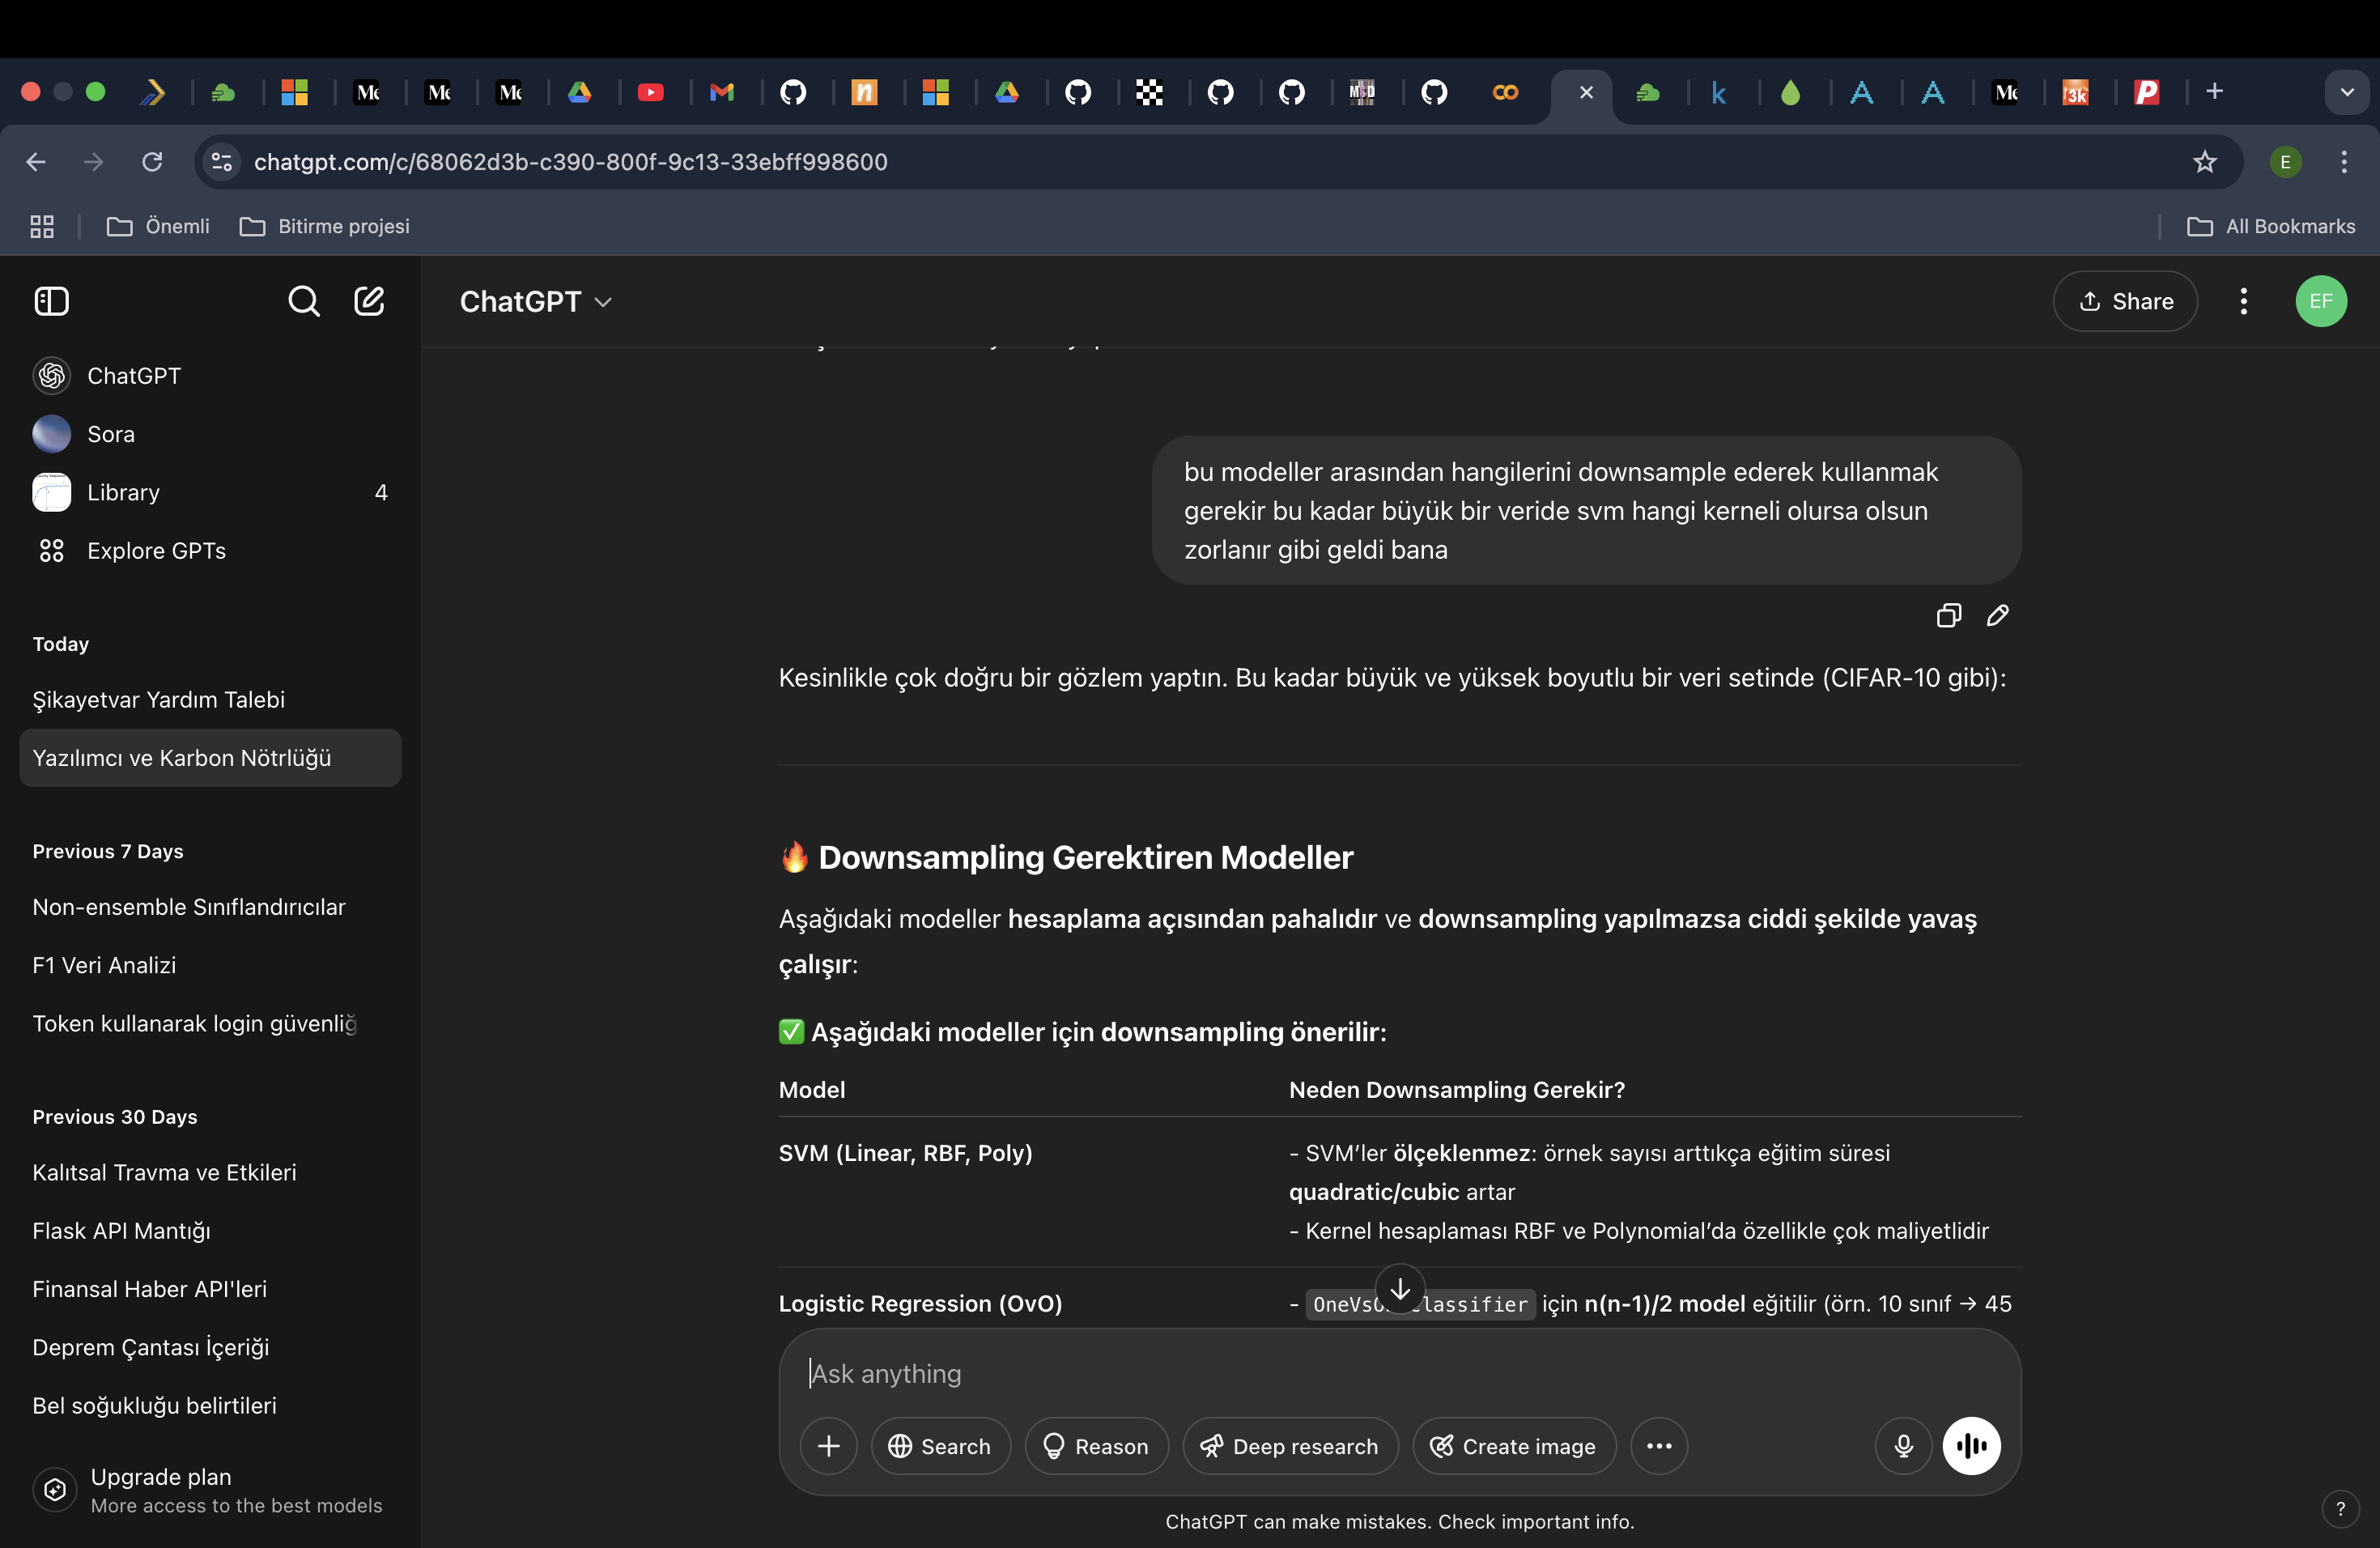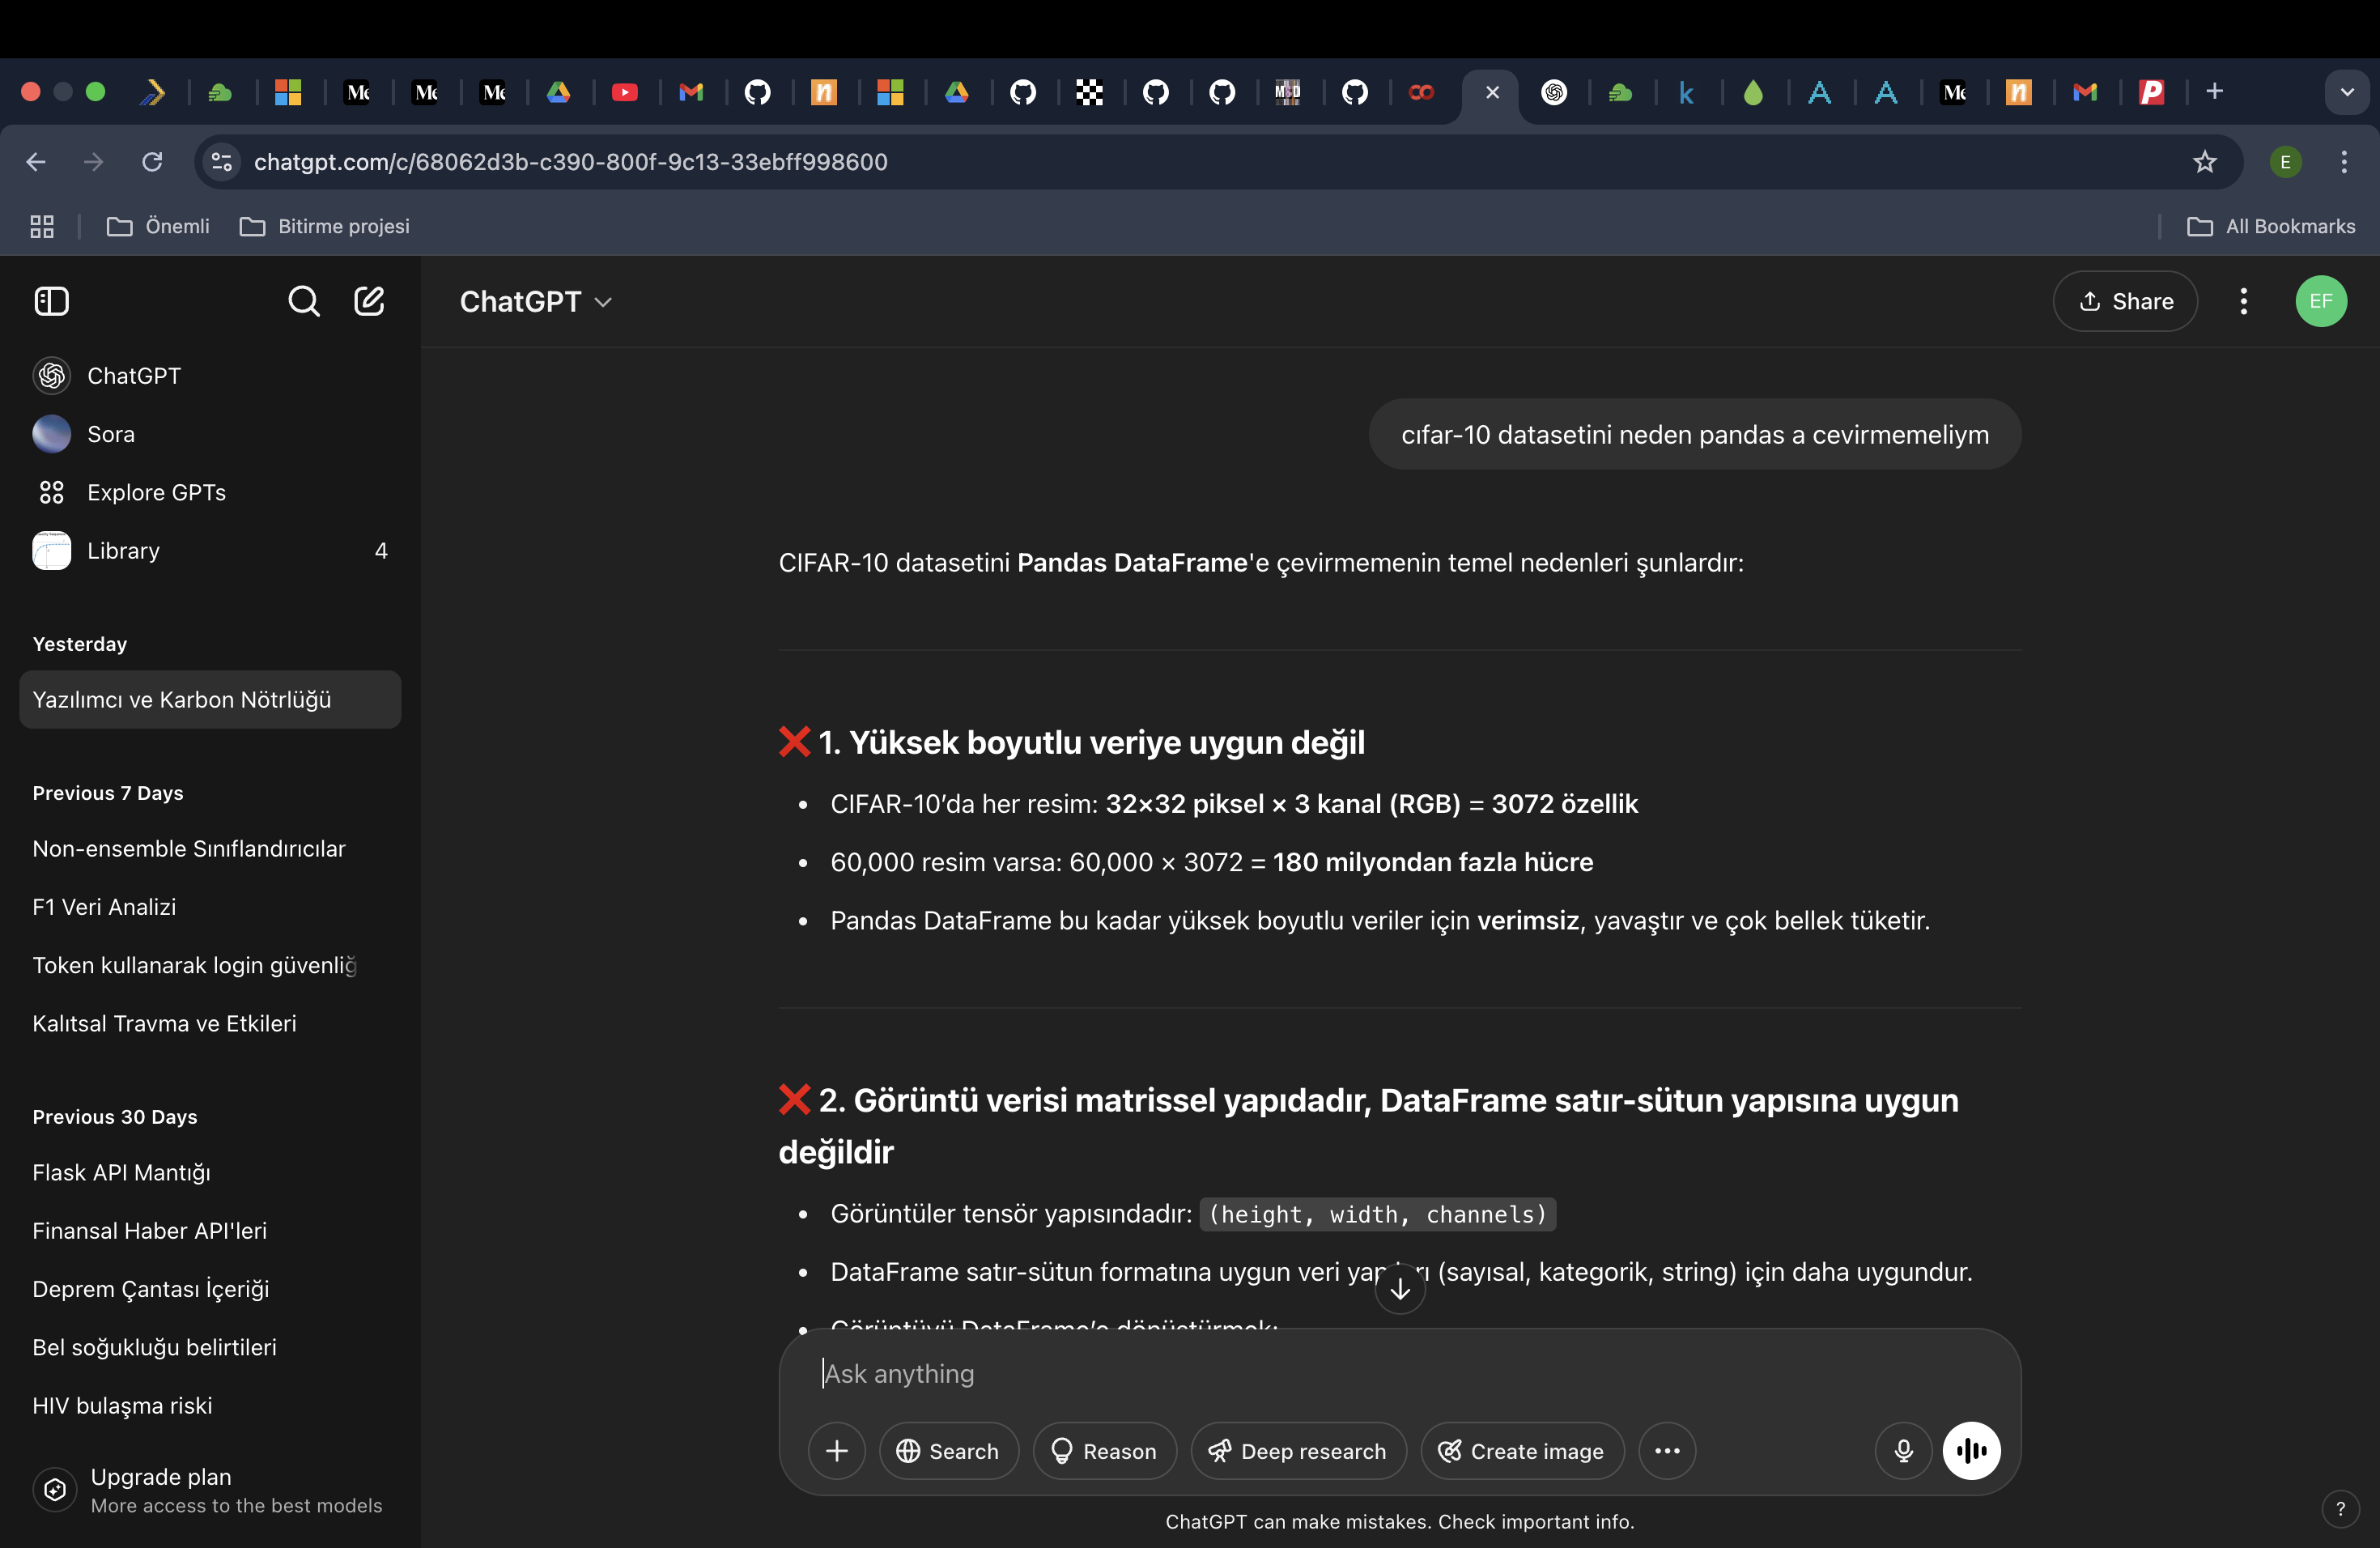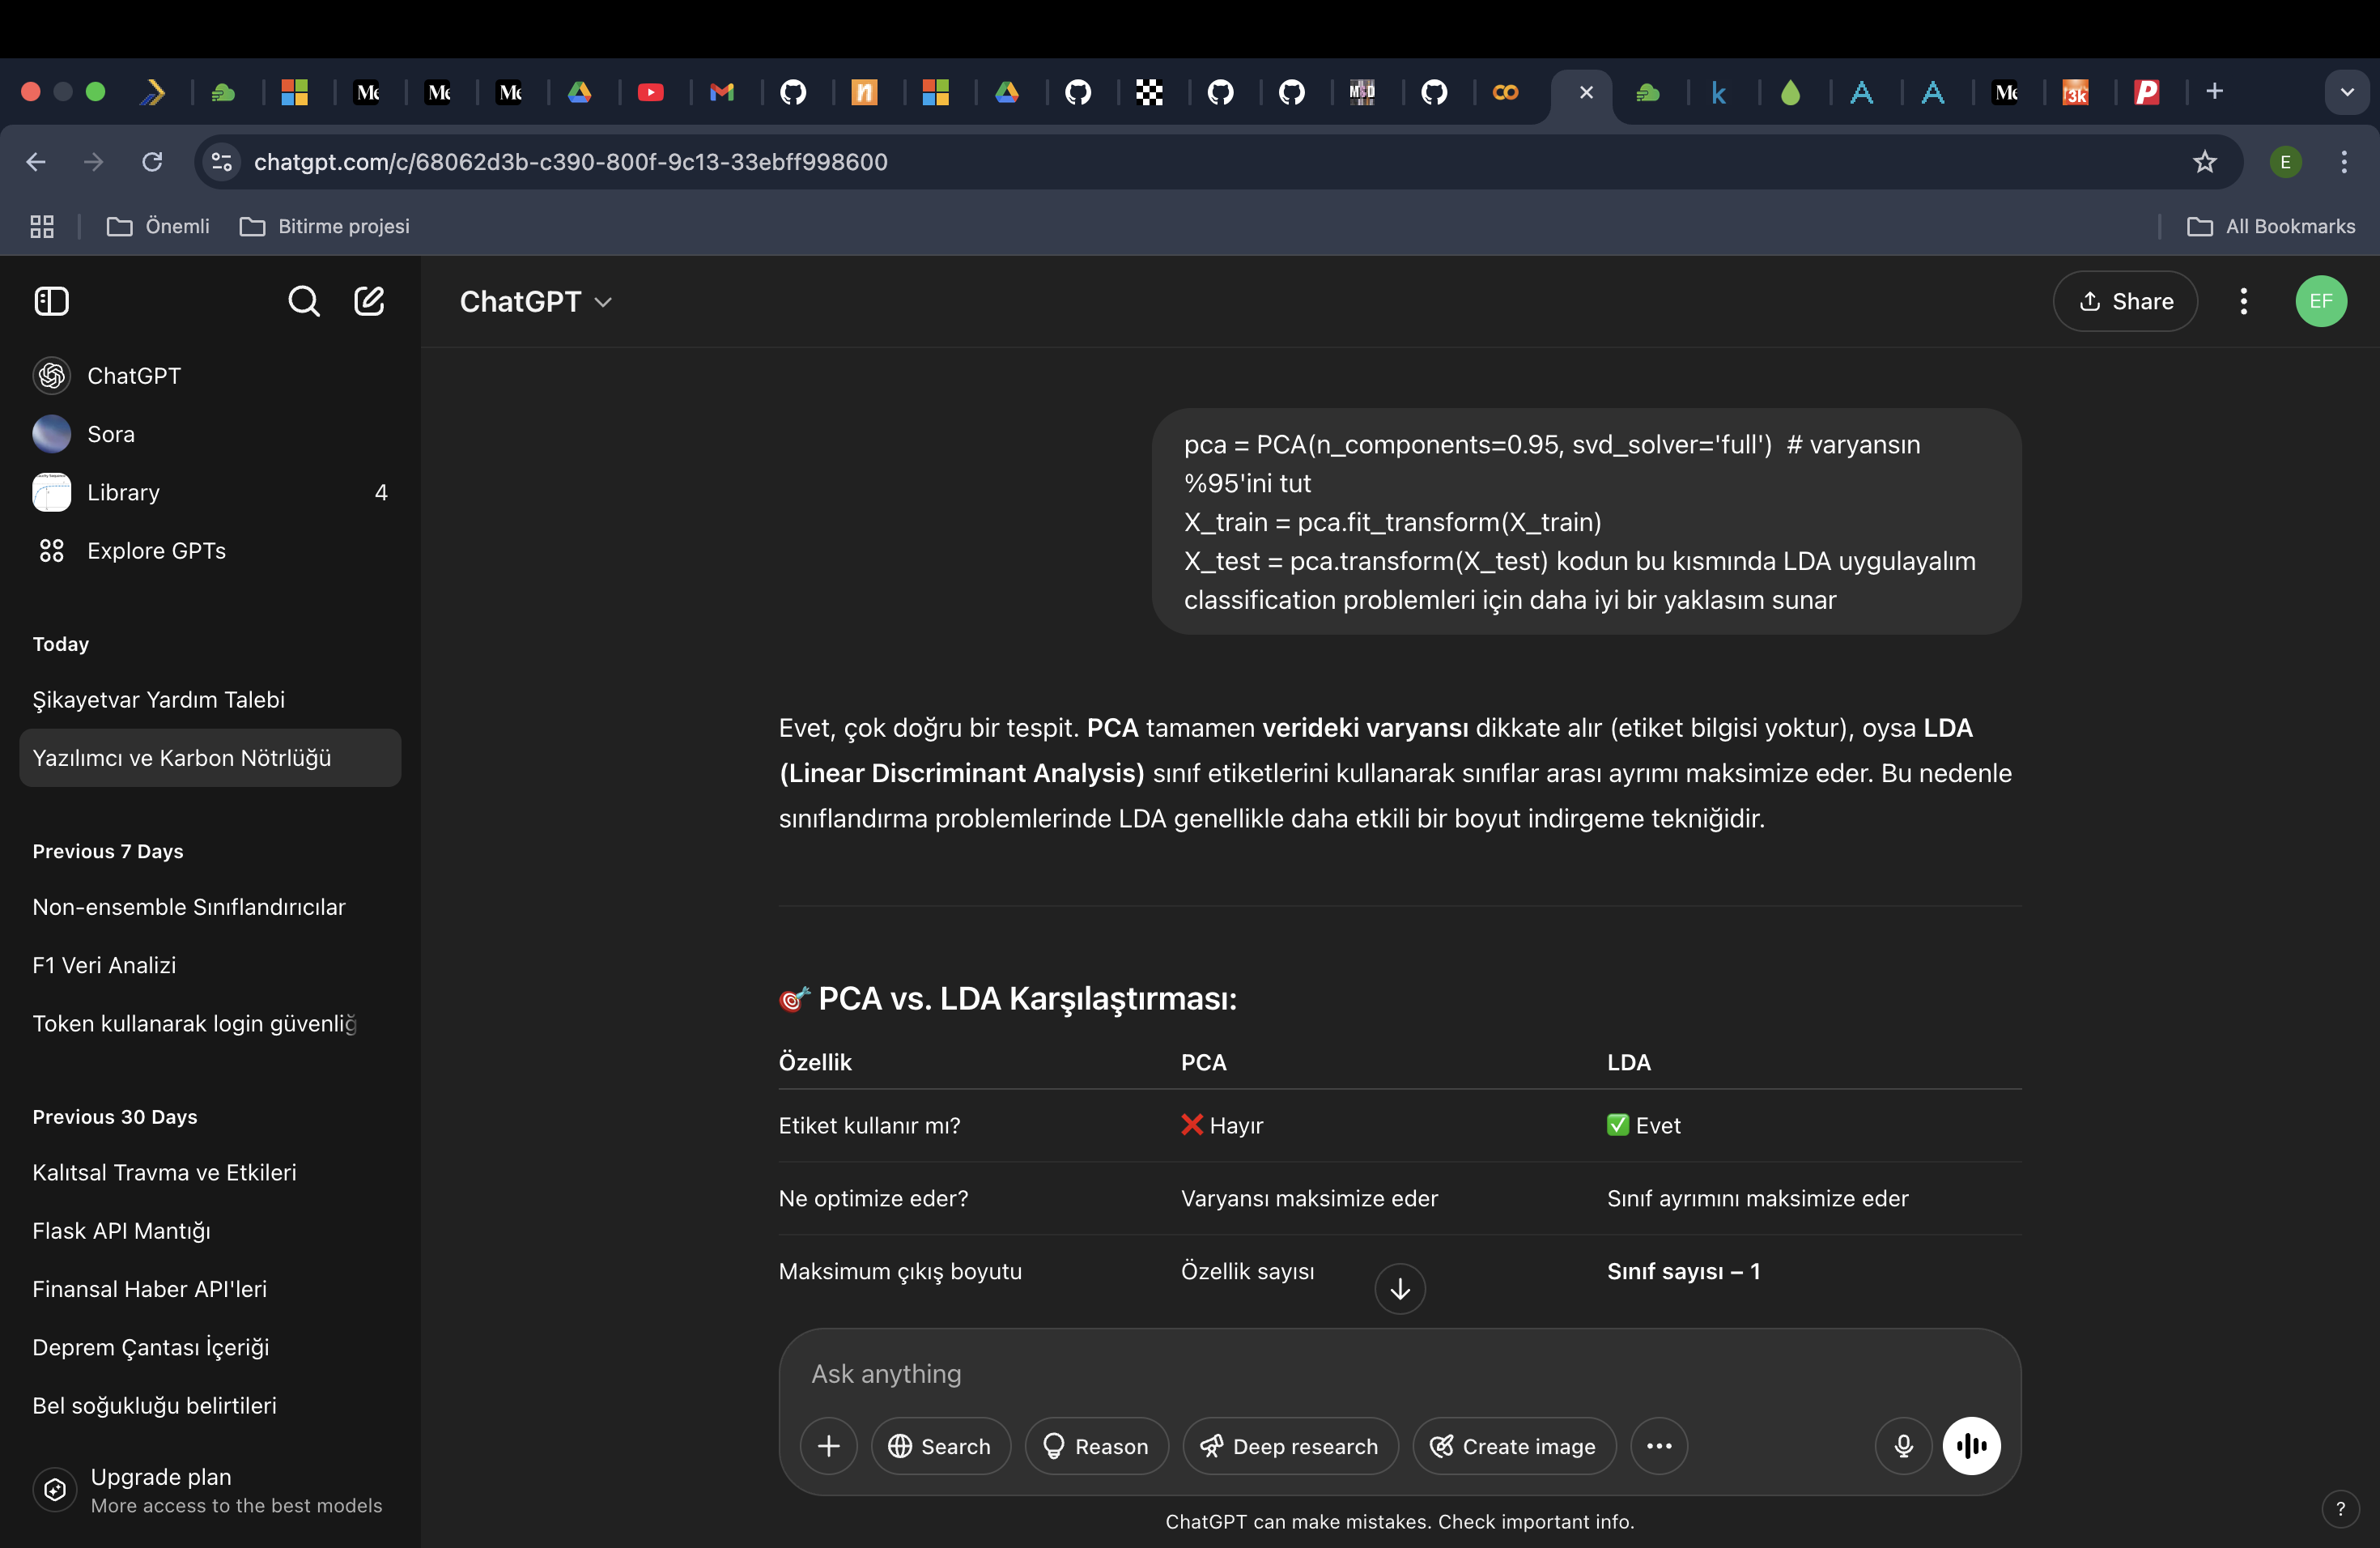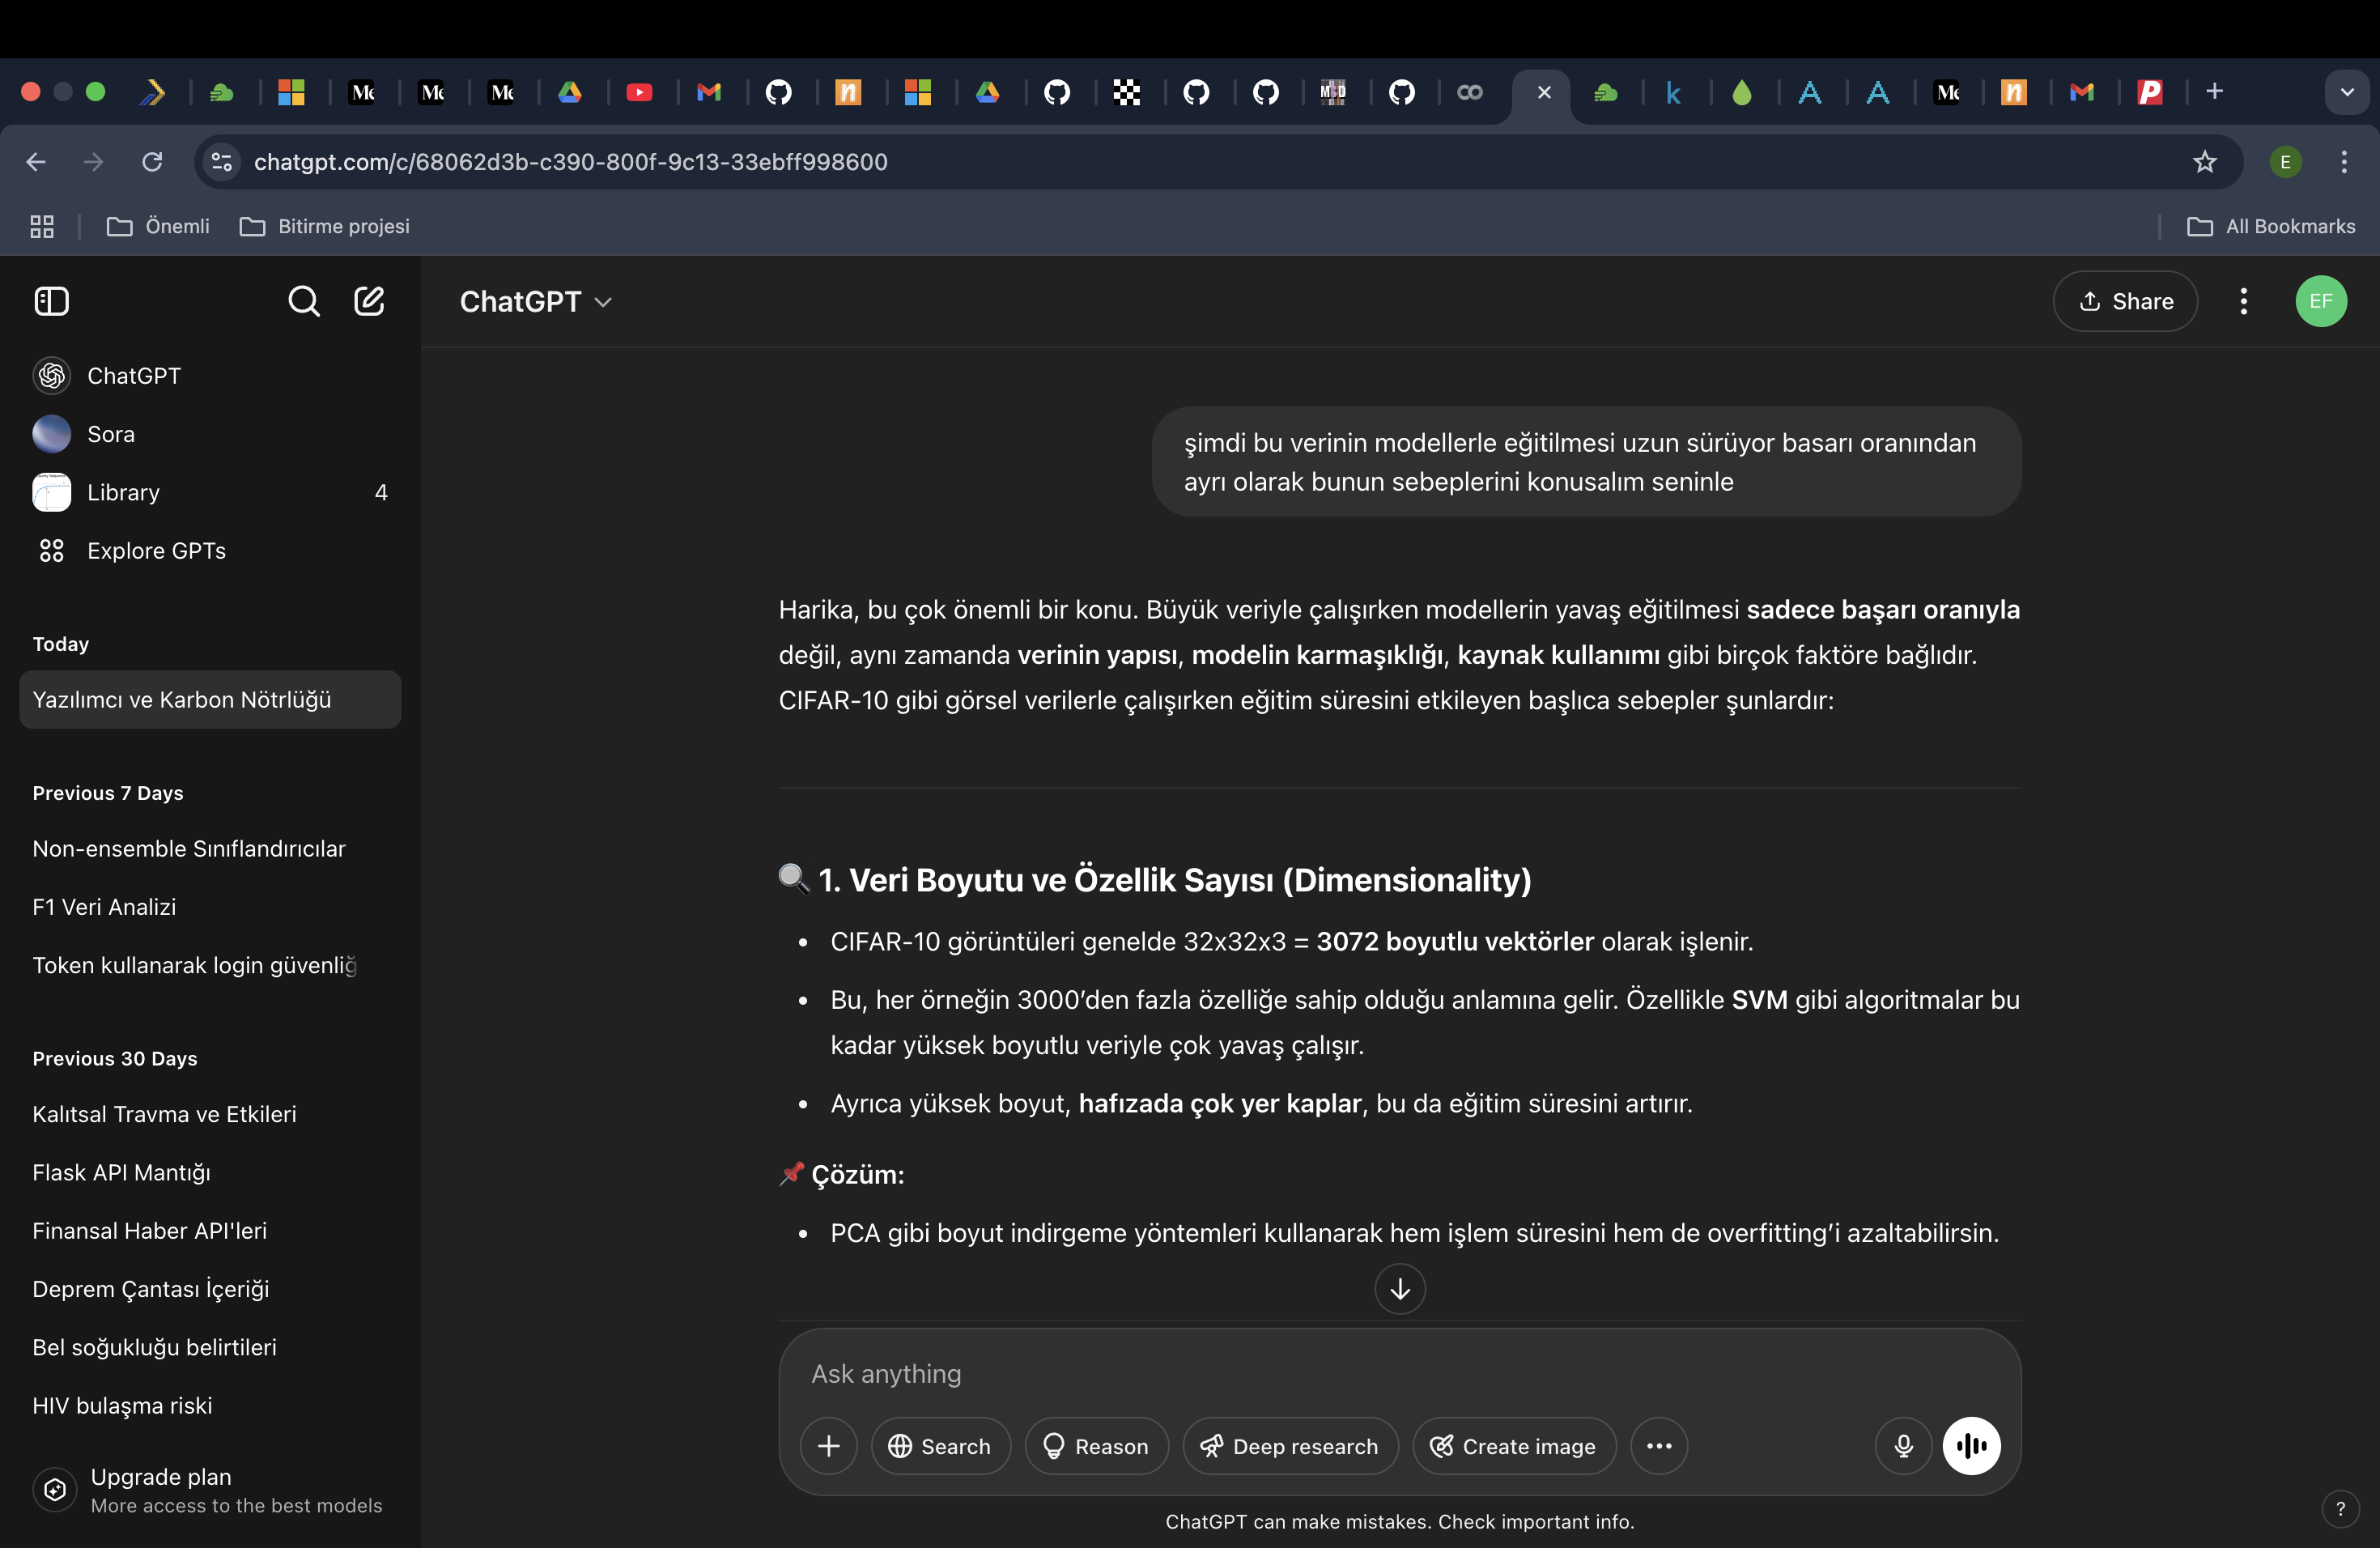

## Q2

In this assignment, you will explore the application of boosting algorithms to a medical image classification problem. The dataset is **PneumoniaMNIST** from the **MedMNIST** collection, available through `tensorflow_datasets` under `medmnist.pneumoniamnist`. PneumoniaMNIST consists of chest X-ray images labeled either as **normal** or **pneumonia**.

The goal is to predict whether a patient shows signs of pneumonia based on their chest X-ray image.

1. Load the PneumoniaMNIST dataset using the `tensorflow_datasets` library. Preprocess the dataset by:
   - Normalizing the pixel values to $[0,1]$,
   - Flattening the $28\times28$ images into vectors suitable for tabular classifiers.

2. Train and evaluate the following models:
   - **Gradient Boosted Decision Trees (GBDT)** using **XGBoost**,
   - **AdaBoost** with **decision stumps** (single-level decision trees) as weak learners,
   - **Gradient Boosting Classifier** using **LightGBM** or **sklearn's GradientBoostingClassifier**.

3. For each model report the test set classification **accuracy**, **precision**, **recall**, **F1-score**, and do a proper error analysis on the values you calculated.

4. Interpret the learned models:
   - Extract and rank the most important pixels (features) contributing to the classification decision (feature importance analysis).
   - Visualize and interpret these "important pixels" on the original $28\times28$ image grid. Discuss whether they align with medical intuition (e.g., lung region emphasis).

5. Discuss computational aspects:
   - Measure and report the **training time** and **inference time** for each boosting model,
   - Report and compare the **model size** (e.g., number of leaves, total size of the trained model).

6. Write a final summary:
   - Summarize the strengths and weaknesses you observed for each boosting method in this specific small-image classification task,
   - Comment on whether boosting methods are well-suited for this type of structured low-dimensional image data compared to neural network approaches.

Hyperparameters such as learning rate, number of estimators, and maximum tree depth should be selected using 5-fold cross-validation or a separate validation split. Pay special attention to **early stopping** where appropriate to avoid overfitting.


In [11]:
!pip install -q medmnist
!pip install torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 609.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 34.4 MB/s eta 0:00:00


In [12]:
import numpy as np
from medmnist import INFO, PneumoniaMNIST
from sklearn.model_selection import train_test_split


data_flag = 'pneumoniamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(__import__('medmnist'), info['python_class'])

train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

X_train = train_dataset.imgs.reshape(-1, 28*28) / 255.0
y_train = train_dataset.labels.ravel()

X_test = test_dataset.imgs.reshape(-1, 28*28) / 255.0
y_test = test_dataset.labels.ravel()

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")



100%|██████████| 4.17M/4.17M [00:00<00:00, 5.37MB/s]


X_train shape: (4708, 784), y_train shape: (4708,)
X_test shape: (624, 784), y_test shape: (624,)


In [13]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold


model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_xgb, X_train, y_train, cv=cv, scoring='accuracy')

print(f"XGBoost Cross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")


model_xgb.fit(X_train, y_train)


y_pred_xgb = model_xgb.predict(X_test)


acc_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb, recall_xgb, fscore_xgb, _ = precision_recall_fscore_support(y_test, y_pred_xgb, average='binary')

print(f"\nXGBoost Test Accuracy: {acc_xgb:.4f}")
print(f"XGBoost Test Precision: {precision_xgb:.4f}")
print(f"XGBoost Test Recall: {recall_xgb:.4f}")
print(f"XGBoost Test F1-Score: {fscore_xgb:.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:20:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:21:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:21:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:21:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

XGBoost Cross-Validation Accuracy Scores: [0.96390658 0.95541401 0.95010616 0.96174283 0.96280553]
Mean CV Accuracy: 0.9588, Std: 0.0053


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:21:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Test Accuracy: 0.8381
XGBoost Test Precision: 0.8029
XGBoost Test Recall: 0.9821
XGBoost Test F1-Score: 0.8835


Accuracy yüzde 83 evet basarı oranı olarak fena bir oran değil cv scoresların da standart sapması çok az baya tutarlı biir model bu basarı oranı için. Ama cv scores un accuracy e oranla bu kadar yüksek olması modelde overfit olma ihtimalini düşündürttü. Şimdi recall ve precision karsılastırması yaptığımızda ise model cok cok fazla pozitif tahmin yapmıs ama bu yaptıgı pozitif tahminleri bazı kısmı yanlıs olmus yani model besbelli overfit olmus.

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np


model_ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), n_estimators=50)


cv_scores_ada = cross_val_score(model_ada, X_train, y_train, cv=5, scoring='accuracy')

print("AdaBoost Cross-Validation Accuracy Scores:", np.round(cv_scores_ada, 4))
print(f"Mean CV Accuracy: {cv_scores_ada.mean():.4f}, Std: {cv_scores_ada.std():.4f}")


model_ada.fit(X_train, y_train)


y_pred_ada = model_ada.predict(X_test)


acc_ada = accuracy_score(y_test, y_pred_ada)
precision_ada, recall_ada, fscore_ada, _ = precision_recall_fscore_support(y_test, y_pred_ada, average='binary')

print(f"\nAdaBoost Test Accuracy: {acc_ada:.4f}")
print(f"AdaBoost Test Precision: {precision_ada:.4f}")
print(f"AdaBoost Test Recall: {recall_ada:.4f}")
print(f"AdaBoost Test F1-Score: {fscore_ada:.4f}")


AdaBoost Cross-Validation Accuracy Scores: [0.9321 0.9565 0.9416 0.9373 0.9416]
Mean CV Accuracy: 0.9418, Std: 0.0081

AdaBoost Test Accuracy: 0.8125
AdaBoost Test Precision: 0.7838
AdaBoost Test Recall: 0.9667
AdaBoost Test F1-Score: 0.8657


accuracy ve cv scoreslara baktığımızda yine fena olmayan bir dogruluk oranı cv score standart spamsı cok az co tutarlı bir dogrulukta. Tabi cv score ortalaması ve accuracynin farkı yine modelde overfit olma ihtimalini düsündğ
ürttü. Precision ve recall farkına baktıgımda yine overfit bir model olmus cok fazla pozitif tahmin yapmış, ama bunların bazıları hatalı.

In [15]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score


model_lgbm = LGBMClassifier()


cv_scores_lgbm = cross_val_score(model_lgbm, X_train, y_train, cv=5, scoring='accuracy')

print("LightGBM Cross-Validation Accuracy Scores:", np.round(cv_scores_lgbm, 4))
print(f"Mean CV Accuracy: {cv_scores_lgbm.mean():.4f}, Std: {cv_scores_lgbm.std():.4f}")


model_lgbm.fit(X_train, y_train)


y_pred_lgbm = model_lgbm.predict(X_test)


acc_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm, recall_lgbm, fscore_lgbm, _ = precision_recall_fscore_support(y_test, y_pred_lgbm, average='binary')

print(f"\nLightGBM Test Accuracy: {acc_lgbm:.4f}")
print(f"LightGBM Test Precision: {precision_lgbm:.4f}")
print(f"LightGBM Test Recall: {recall_lgbm:.4f}")
print(f"LightGBM Test F1-Score: {fscore_lgbm:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2795, number of negative: 971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085749 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125840
[LightGBM] [Info] Number of data points in the train set: 3766, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742167 -> initscore=1.057261
[LightGBM] [Info] Start training from score 1.057261


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2795, number of negative: 971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125651
[LightGBM] [Info] Number of data points in the train set: 3766, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742167 -> initscore=1.057261
[LightGBM] [Info] Start training from score 1.057261


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2795, number of negative: 971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125514
[LightGBM] [Info] Number of data points in the train set: 3766, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742167 -> initscore=1.057261
[LightGBM] [Info] Start training from score 1.057261


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2795, number of negative: 972
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126043
[LightGBM] [Info] Number of data points in the train set: 3767, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.741970 -> initscore=1.056232
[LightGBM] [Info] Start training from score 1.056232


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 2796, number of negative: 971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125543
[LightGBM] [Info] Number of data points in the train set: 3767, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742235 -> initscore=1.057619
[LightGBM] [Info] Start training from score 1.057619


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM Cross-Validation Accuracy Scores: [0.9459 0.966  0.9607 0.9575 0.9607]
Mean CV Accuracy: 0.9582, Std: 0.0067
[LightGBM] [Info] Number of positive: 3494, number of negative: 1214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129476
[LightGBM] [Info] Number of data points in the train set: 4708, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742141 -> initscore=1.057127
[LightGBM] [Info] Start training from score 1.057127

LightGBM Test Accuracy: 0.8478
LightGBM Test Precision: 0.8158
LightGBM Test Recall: 0.9769
LightGBM Test F1-Score: 0.8891


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Yine diğer modeller gibi bu modelimiz de overfit olmus ama en azından accuracy olarak hafif onlara göre daha basarılı.

In [17]:
import time


training_times = {}
inference_times = {}


start_time = time.time()
model_ada.fit(X_train, y_train)
training_times["AdaBoost"] = time.time() - start_time

start_time = time.time()
model_ada.predict(X_test)
inference_times["AdaBoost"] = time.time() - start_time


start_time = time.time()
model_lgbm.fit(X_train, y_train)
training_times["LightGBM"] = time.time() - start_time

start_time = time.time()
model_lgbm.predict(X_test)
inference_times["LightGBM"] = time.time() - start_time


start_time = time.time()
model_xgb.fit(X_train, y_train)
training_times["XGBoost"] = time.time() - start_time

start_time = time.time()
model_xgb.predict(X_test)
inference_times["XGBoost"] = time.time() - start_time


print("Model Training and Inference Times (in seconds):")
for model_name in training_times:
    print(f"{model_name}: Training = {training_times[model_name]:.2f}s, Inference = {inference_times[model_name]:.2f}s")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 3494, number of negative: 1214
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 129476
[LightGBM] [Info] Number of data points in the train set: 4708, number of used features: 784
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.742141 -> initscore=1.057127
[LightGBM] [Info] Start training from score 1.057127


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model Training and Inference Times (in seconds):
AdaBoost: Training = 19.05s, Inference = 0.04s
LightGBM: Training = 8.16s, Inference = 0.01s
XGBoost: Training = 8.17s, Inference = 0.01s


train ve uygulamaa zamanlarına baktıgımızda adaboostun train ve inference  zamanı 2 kat diğerlerinden yüksek bunun sebebi de modell karar ağaçlarında küçük ve fazla ağac kullanılr ve hatalar her adımda hesaplanır bu da modelin her adımdaki kompleksliğini artırır.

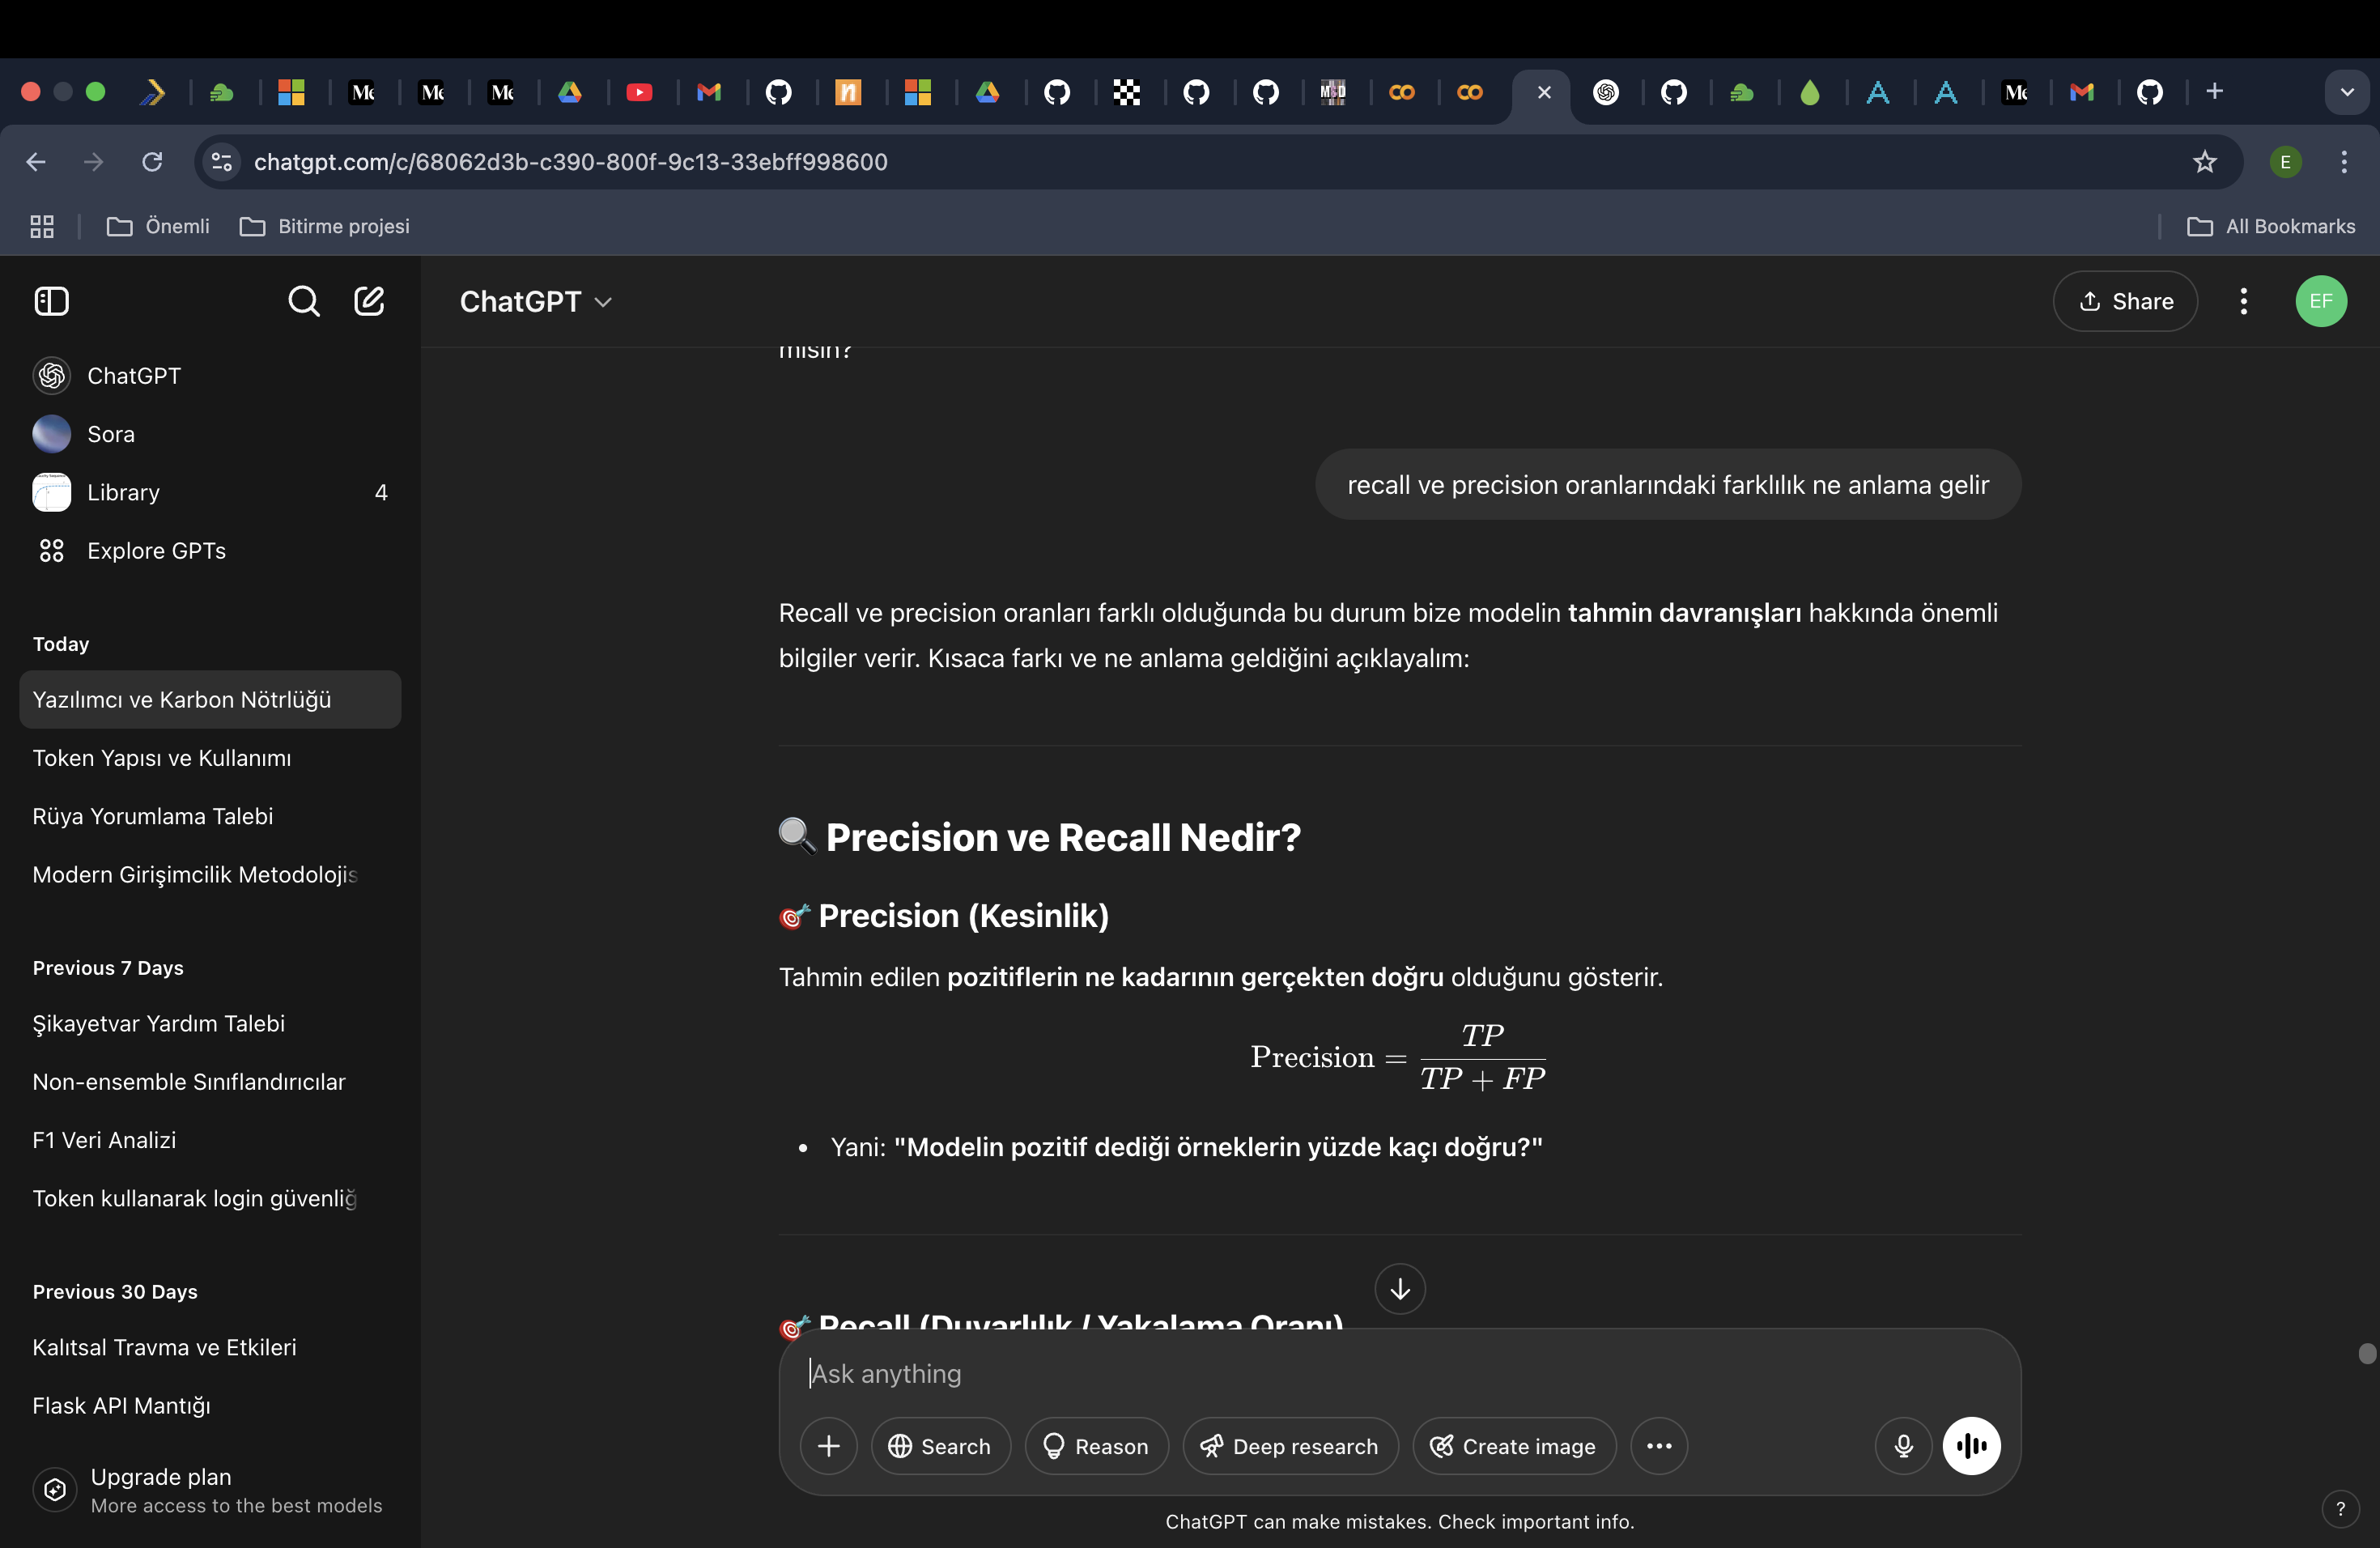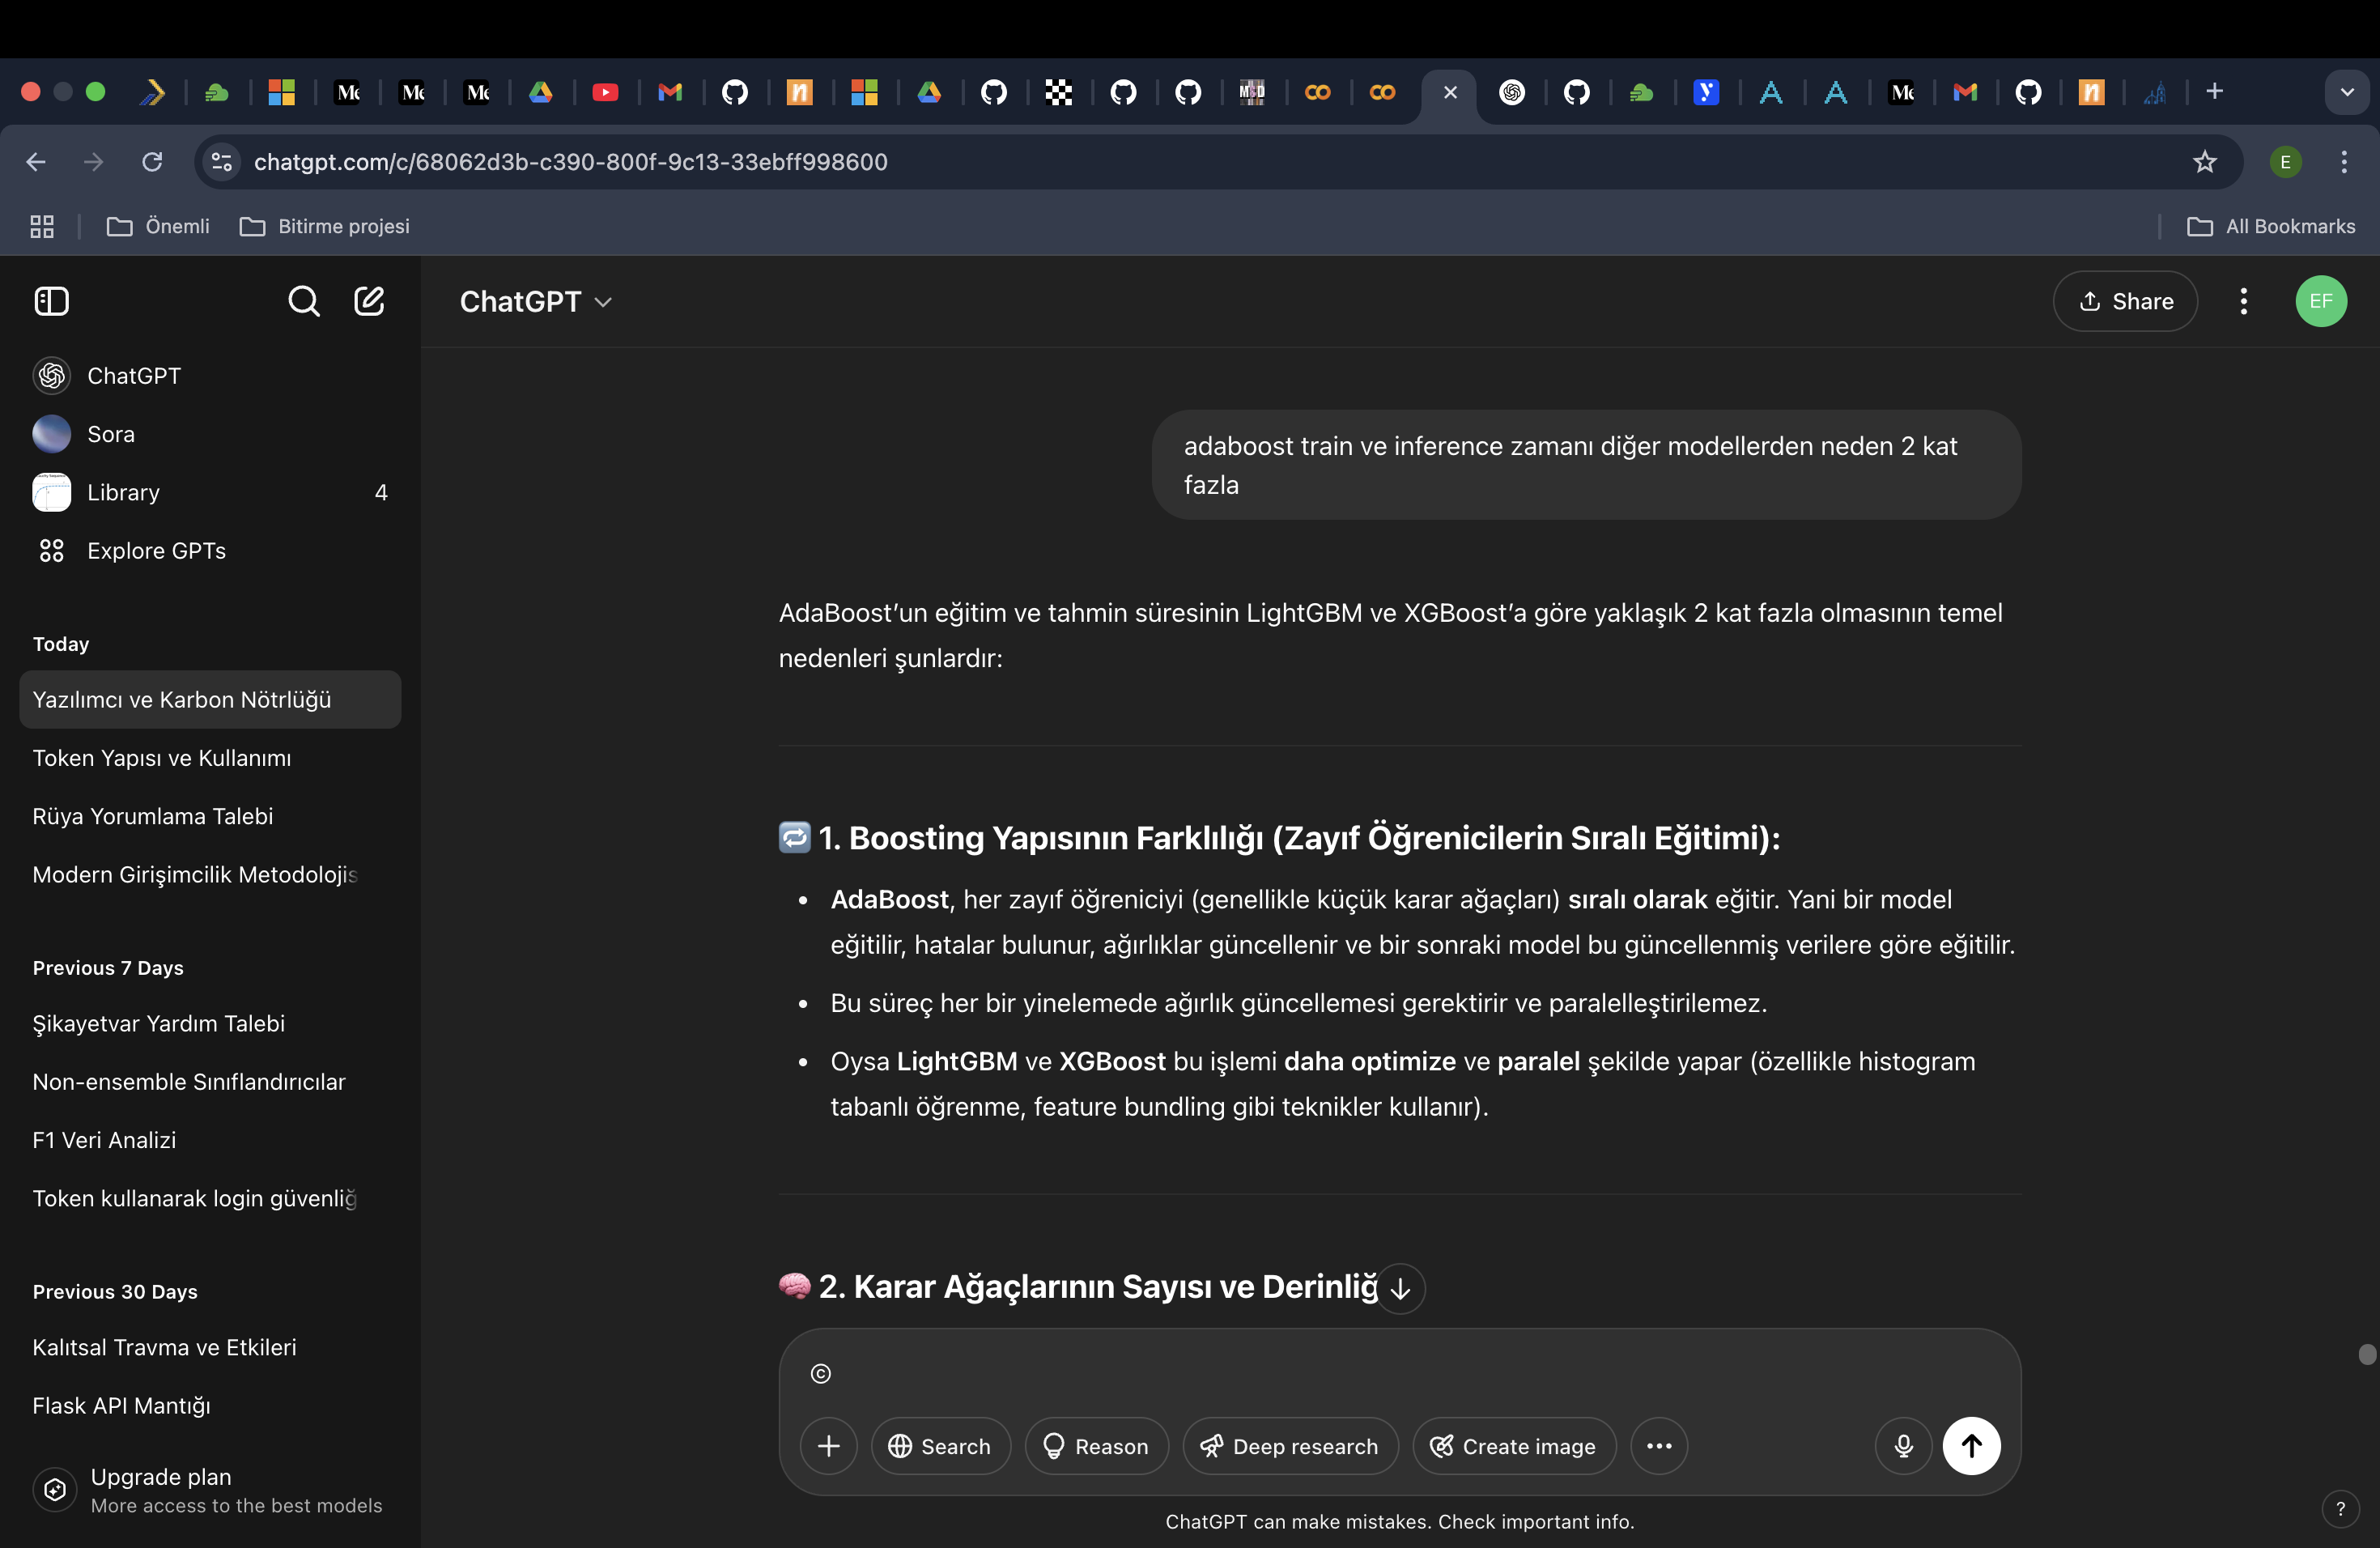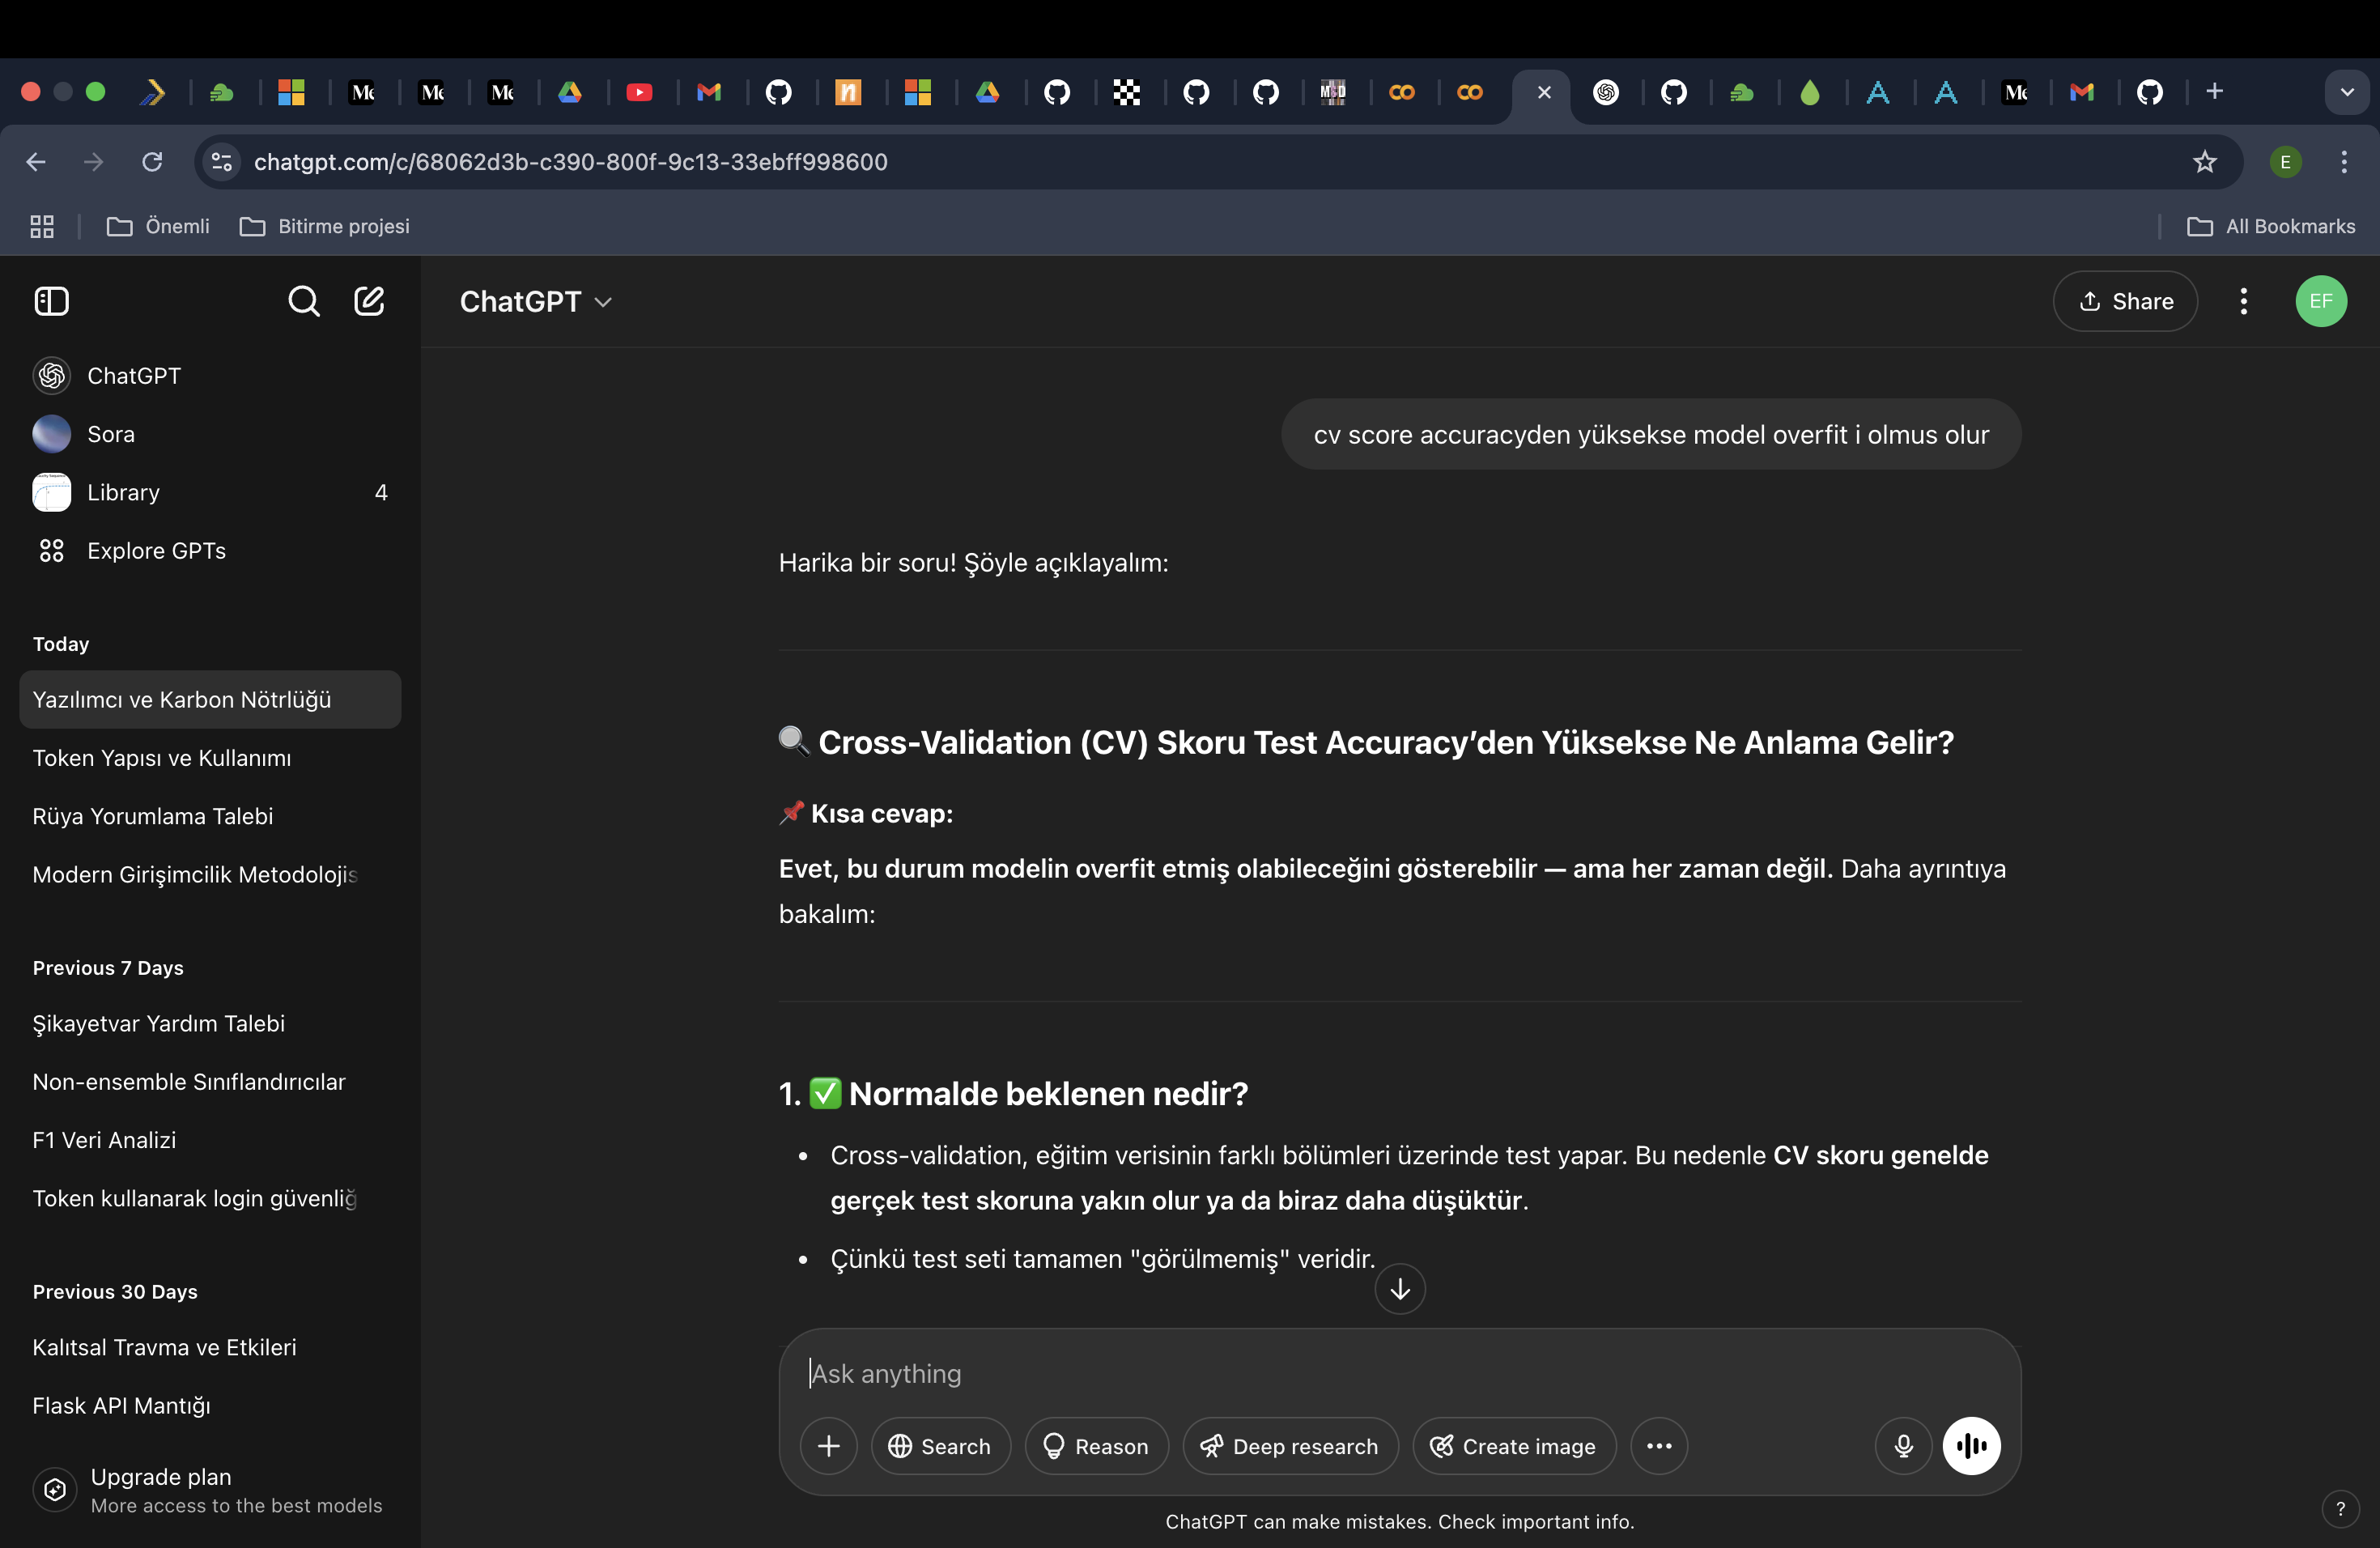

## Q3

In this question, you will investigate the use of **autoencoders** for compressing high-dimensional text data into a lower-dimensional latent space. You will use the **IMDB movie reviews dataset** from `tensorflow_datasets` and develop a pipeline based on **count vectorization**, followed by a **fully-connected autoencoder**.  This question focuses on **unsupervised representation learning** and reconstruction accuracy in the **bag-of-words (BoW)** paradigm.

#### **Part I: Preprocessing Pipeline**

1. Load the `imdb_reviews` dataset using `tensorflow_datasets`.
2. Construct a preprocessing pipeline consisting of the following steps:
   - **Text cleaning**: remove punctuation and convert all text to lowercase.
   - **Tokenization**: split the review into word tokens.
   - **Count-based vectorization**:
     - Use `sklearn.feature_extraction.text.CountVectorizer`,
     - Limit the vocabulary to the top $V = 5000$ most frequent words,
     - Represent each review as a **$V$-dimensional sparse count vector**.

3. Optionally, apply TF scaling or binary indicator (0/1) encoding to the count vectors. Justify your choice.

#### **Part II: Autoencoder Architecture**

4. Build a **fully-connected feedforward autoencoder** in TensorFlow/Keras:
   - The **input layer** accepts a $V$-dimensional BoW vector,
   - The **encoder** compresses it through one or more dense layers to a **latent space** of dimension $d \ll V$ (e.g., $d = 32$ or $64$),
   - The **decoder** maps the latent representation back to a $V$-dimensional output using symmetric architecture,
   - Use **sigmoid activation** on the final output layer to model per-word presence/absence (binary cross-entropy loss),
   - Apply **dropout** and/or **L2 regularization** to mitigate overfitting.

#### **Part III: Training and Evaluation**

5. Train the autoencoder on the training portion of the dataset using:
   - Mini-batch SGD or Adam optimizer,
   - Binary cross-entropy loss,
   - A held-out validation set for early stopping.

6. Evaluate the quality of the trained autoencoder on the test set:
   - For each reconstructed output $\hat{x}$ and corresponding input $x$, compute the **binary prediction** $\hat{x}_i = 1$ if $\hat{x}_i > 0.5$,
   - Compute **per-sample accuracy**: proportion of correctly reconstructed binary entries per BoW vector together with a proper error analysis,
   - Report the **mean accuracy** across all test samples together with a proper error analysis.

7. In addition, report:
   - The total number of parameters in the model,
   - The average compression ratio (input dimension / latent dimension),
   - A few example reconstructions: for 5 randomly chosen reviews, list the top-10 most frequent words in the original and reconstructed BoW vectors. Discuss any semantic degradation or preservation.

#### **Part IV: Latent Space Visualization and Interpretation**

8. Extract the **latent representations** of 1000 test reviews.
9. Use PCA to reduce the $d$-dimensional latent codes to 2D and visualize the resulting plot.
   - Color the points based on **sentiment label** (positive or negative, available in the dataset but not used during training),
   - Discuss whether the autoencoder latent space **implicitly clusters** sentences by sentiment, even though the model was trained in an unsupervised manner.


In [1]:
!pip install tensorflow-datasets


In [2]:
import tensorflow_datasets as tfds


data, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data, test_data = data['train'], data['test']



import numpy as np
from sklearn.feature_extraction.text import CountVectorizer


train_texts = [x.decode('utf-8') for x, _ in tfds.as_numpy(train_data)]
test_texts = [x.decode('utf-8') for x, _ in tfds.as_numpy(test_data)]



vectorizer = CountVectorizer(
    max_features=5000,
    binary=True,
    lowercase=True,
    stop_words='english'
)


X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.VNF3JJ_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.VNF3JJ_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.VNF3JJ_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


Tüm yorumlar string'e çevrilir (decode('utf-8')).

CountVectorizer: Bag-of-Words oluşturur. En çok geçen 5000 kelime vektörde yer alır.

binary=True: Her kelimenin var/yok bilgisi (0/1) tutulur, bu da sigmoid + binary_crossentropy için uygundur.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

input_dim = X_train.shape[1]
latent_dim = 64


input_layer = layers.Input(shape=(input_dim,))
x = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(input_layer)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
latent = layers.Dense(latent_dim, activation='relu')(x)


x = layers.Dense(256, activation='relu')(latent)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
output_layer = layers.Dense(input_dim, activation='sigmoid')(x)


autoencoder = tf.keras.Model(input_layer, output_layer)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     5,121,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5000)           │     5,125,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,804,680 (41.22 MB)

 Trainable params: 10,804,680 (41.22 MB)

 Non-trainable params: 0 (0.00 B)

input_dim = 5000, çünkü BoW vektör uzunluğu bu.

Encoder kısmı yavaş yavaş veriyi latent_dim = 64 boyuta sıkıştırır.

Dropout ve L2 regularizer, aşırı öğrenmeyi (overfitting) önler.

In [4]:
from sklearn.model_selection import train_test_split


X_train_dense = X_train.toarray().astype('float32')
X_test_dense = X_test.toarray().astype('float32')


X_train_split, X_val_split = train_test_split(X_train_dense, test_size=0.1, random_state=42)


history = autoencoder.fit(
    X_train_split, X_train_split,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_data=(X_val_split, X_val_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)


Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 47s 511ms/step - loss: 0.2604 - val_loss: 0.0755
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 70s 383ms/step - loss: 0.0733 - val_loss: 0.0692
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 404ms/step - loss: 0.0683 - val_loss: 0.0657
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 35s 396ms/step - loss: 0.0655 - val_loss: 0.0637
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 412ms/step - loss: 0.0633 - val_loss: 0.0623
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 389ms/step - loss: 0.0619 - val_loss: 0.0615
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - loss: 0.0616 - val_loss: 0.0610
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - loss: 0.0612 - val_loss: 0.0605
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 39s 378ms/step - loss: 0.0603 - val_loss: 0.0601
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 394ms/step - loss: 0.0599 - val_loss: 0.0598
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - loss: 0.0595 - val_loss: 0.0594
Epoch 12/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 41

In [5]:

X_pred = autoencoder.predict(X_test_dense)

X_pred_binary = (X_pred > 0.5).astype('int')
X_true_binary = X_test_dense.astype('int')


accuracies = (X_pred_binary == X_true_binary).mean(axis=1)
mean_accuracy = np.mean(accuracies)

print(f"Mean reconstruction accuracy on test set: {mean_accuracy:.4f}")


782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step
Mean reconstruction accuracy on test set: 0.9866


In [6]:

total_params = autoencoder.count_params()
compression_ratio = input_dim / latent_dim

print(f"Total parameters: {total_params}")
print(f"Compression ratio (input_dim / latent_dim): {compression_ratio:.2f}")


Total parameters: 10804680
Compression ratio (input_dim / latent_dim): 78.12


In [7]:
import random

inv_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

for i in random.sample(range(len(X_test_dense)), 5):
    original_indices = np.argsort(-X_test_dense[i])[:10]
    reconstructed_indices = np.argsort(-X_pred[i])[:10]

    original_words = [inv_vocab.get(idx, '') for idx in original_indices]
    reconstructed_words = [inv_vocab.get(idx, '') for idx in reconstructed_indices]

    print(f"\nSample {i}:")
    print(f"Top-10 Original Words:      {original_words}")
    print(f"Top-10 Reconstructed Words: {reconstructed_words}")



Sample 19681:
Top-10 Original Words:      ['youth', 'writer', 'work', 'worse', 'wife', 'william', 'win', 'winning', 'want', 'version']
Top-10 Reconstructed Words: ['br', 'film', 'like', 'woman', 'life', 'love', 'just', 'man', 'time', 'story']

Sample 1546:
Top-10 Original Words:      ['willing', 'way', 'turning', 'touch', 'things', 'thomas', 'talks', 'subtle', 'strong', 'shows']
Top-10 Reconstructed Words: ['movie', 'character', 'story', 'good', 'characters', 'br', 'life', 'acting', 'really', 'just']

Sample 208:
Top-10 Original Words:      ['wasn', 'watch', 'uses', 'tom', 'times', 'takes', 'style', 'soul', 'service', 'scenes']
Top-10 Reconstructed Words: ['movie', 'like', 'just', 'good', 'scenes', 'story', 'really', 'bad', 'love', 'pretty']

Sample 19061:
Top-10 Original Words:      ['1950', 'white', 'watch', 'vicious', 'video', 'urban', 'tv', 'time', 'superb', 'street']
Top-10 Reconstructed Words: ['film', 'years', 'best', 'dvd', 'john', 'movie', 'great', 'time', 'cast', 'films']

S

Modelin çıktısını alırsın (y_pred = autoencoder.predict(X_test.toarray()))

y_pred > 0.5 → BoW 1 sayılır.

Her test örneği için gerçek ve tahmin vektörlerini karşılaştırırsın (doğru/yanlış kelime varlığı).

Ortalama doğruluğu ve örnekleri raporlarsın.



32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


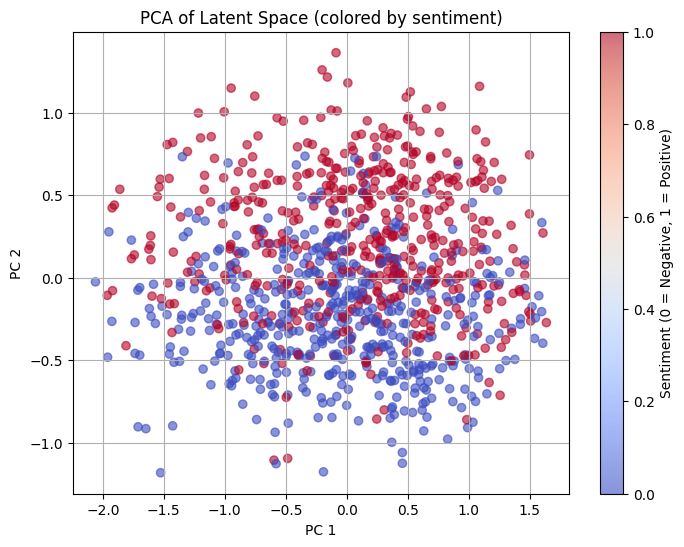

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

test_labels = np.array([label for _, label in tfds.as_numpy(test_data)])


encoded_model = tf.keras.Model(input_layer, latent)
latent_vectors = encoded_model.predict(X_test_dense[:1000])
labels_1000 = test_labels[:1000]

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

-
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels_1000, cmap='coolwarm', alpha=0.6)
plt.title("PCA of Latent Space (colored by sentiment)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.colorbar(label="Sentiment (0 = Negative, 1 = Positive)")
plt.grid(True)
plt.show()


encoder_model: Autoencoder’ın sadece encoder kısmını çıkarıp latent vektör elde eder.

PCA: 64 boyutlu latent kodları 2D'ye indirger.

plt.scatter: Verileri duygularına göre renklendirip çizer.

test verisinden alınan yorumların latent vector 2 boyutlu uzaya indirgenmiş halleri, pozitif ve negatif olarak kısmen ayrışmış kümeler oluşturuyor. Bu, modelin sentiment etiketlerini hiç görmeden bile bu bilgiyi dolaylı olarak öğrendiğini gösteriyor. Duygu bilgisi yorumlardaki iyiyi ve kötüyü simgeleyen sıfatlardan alınıyor . Autoencoder, her yorumu bir kelime sıklığı vektörüne (BoW) dönüştürüp, bu vektörü sıkıştırarak yeniden üretmeye çalıştığı için, kelime örüntülerini öğrenir. Bu örüntüler ise genellikle duyguya göre farklılık gösterdiğinden, gizli temsillerde duyguya göre ayrışmalar ortaya çıkar. Bu sayede duyguları içeren anlamlı bir uzay olusturulur ve etiket olmamasına rağmen kısmen clustering gibi bir durum ortaya çıkıyor.

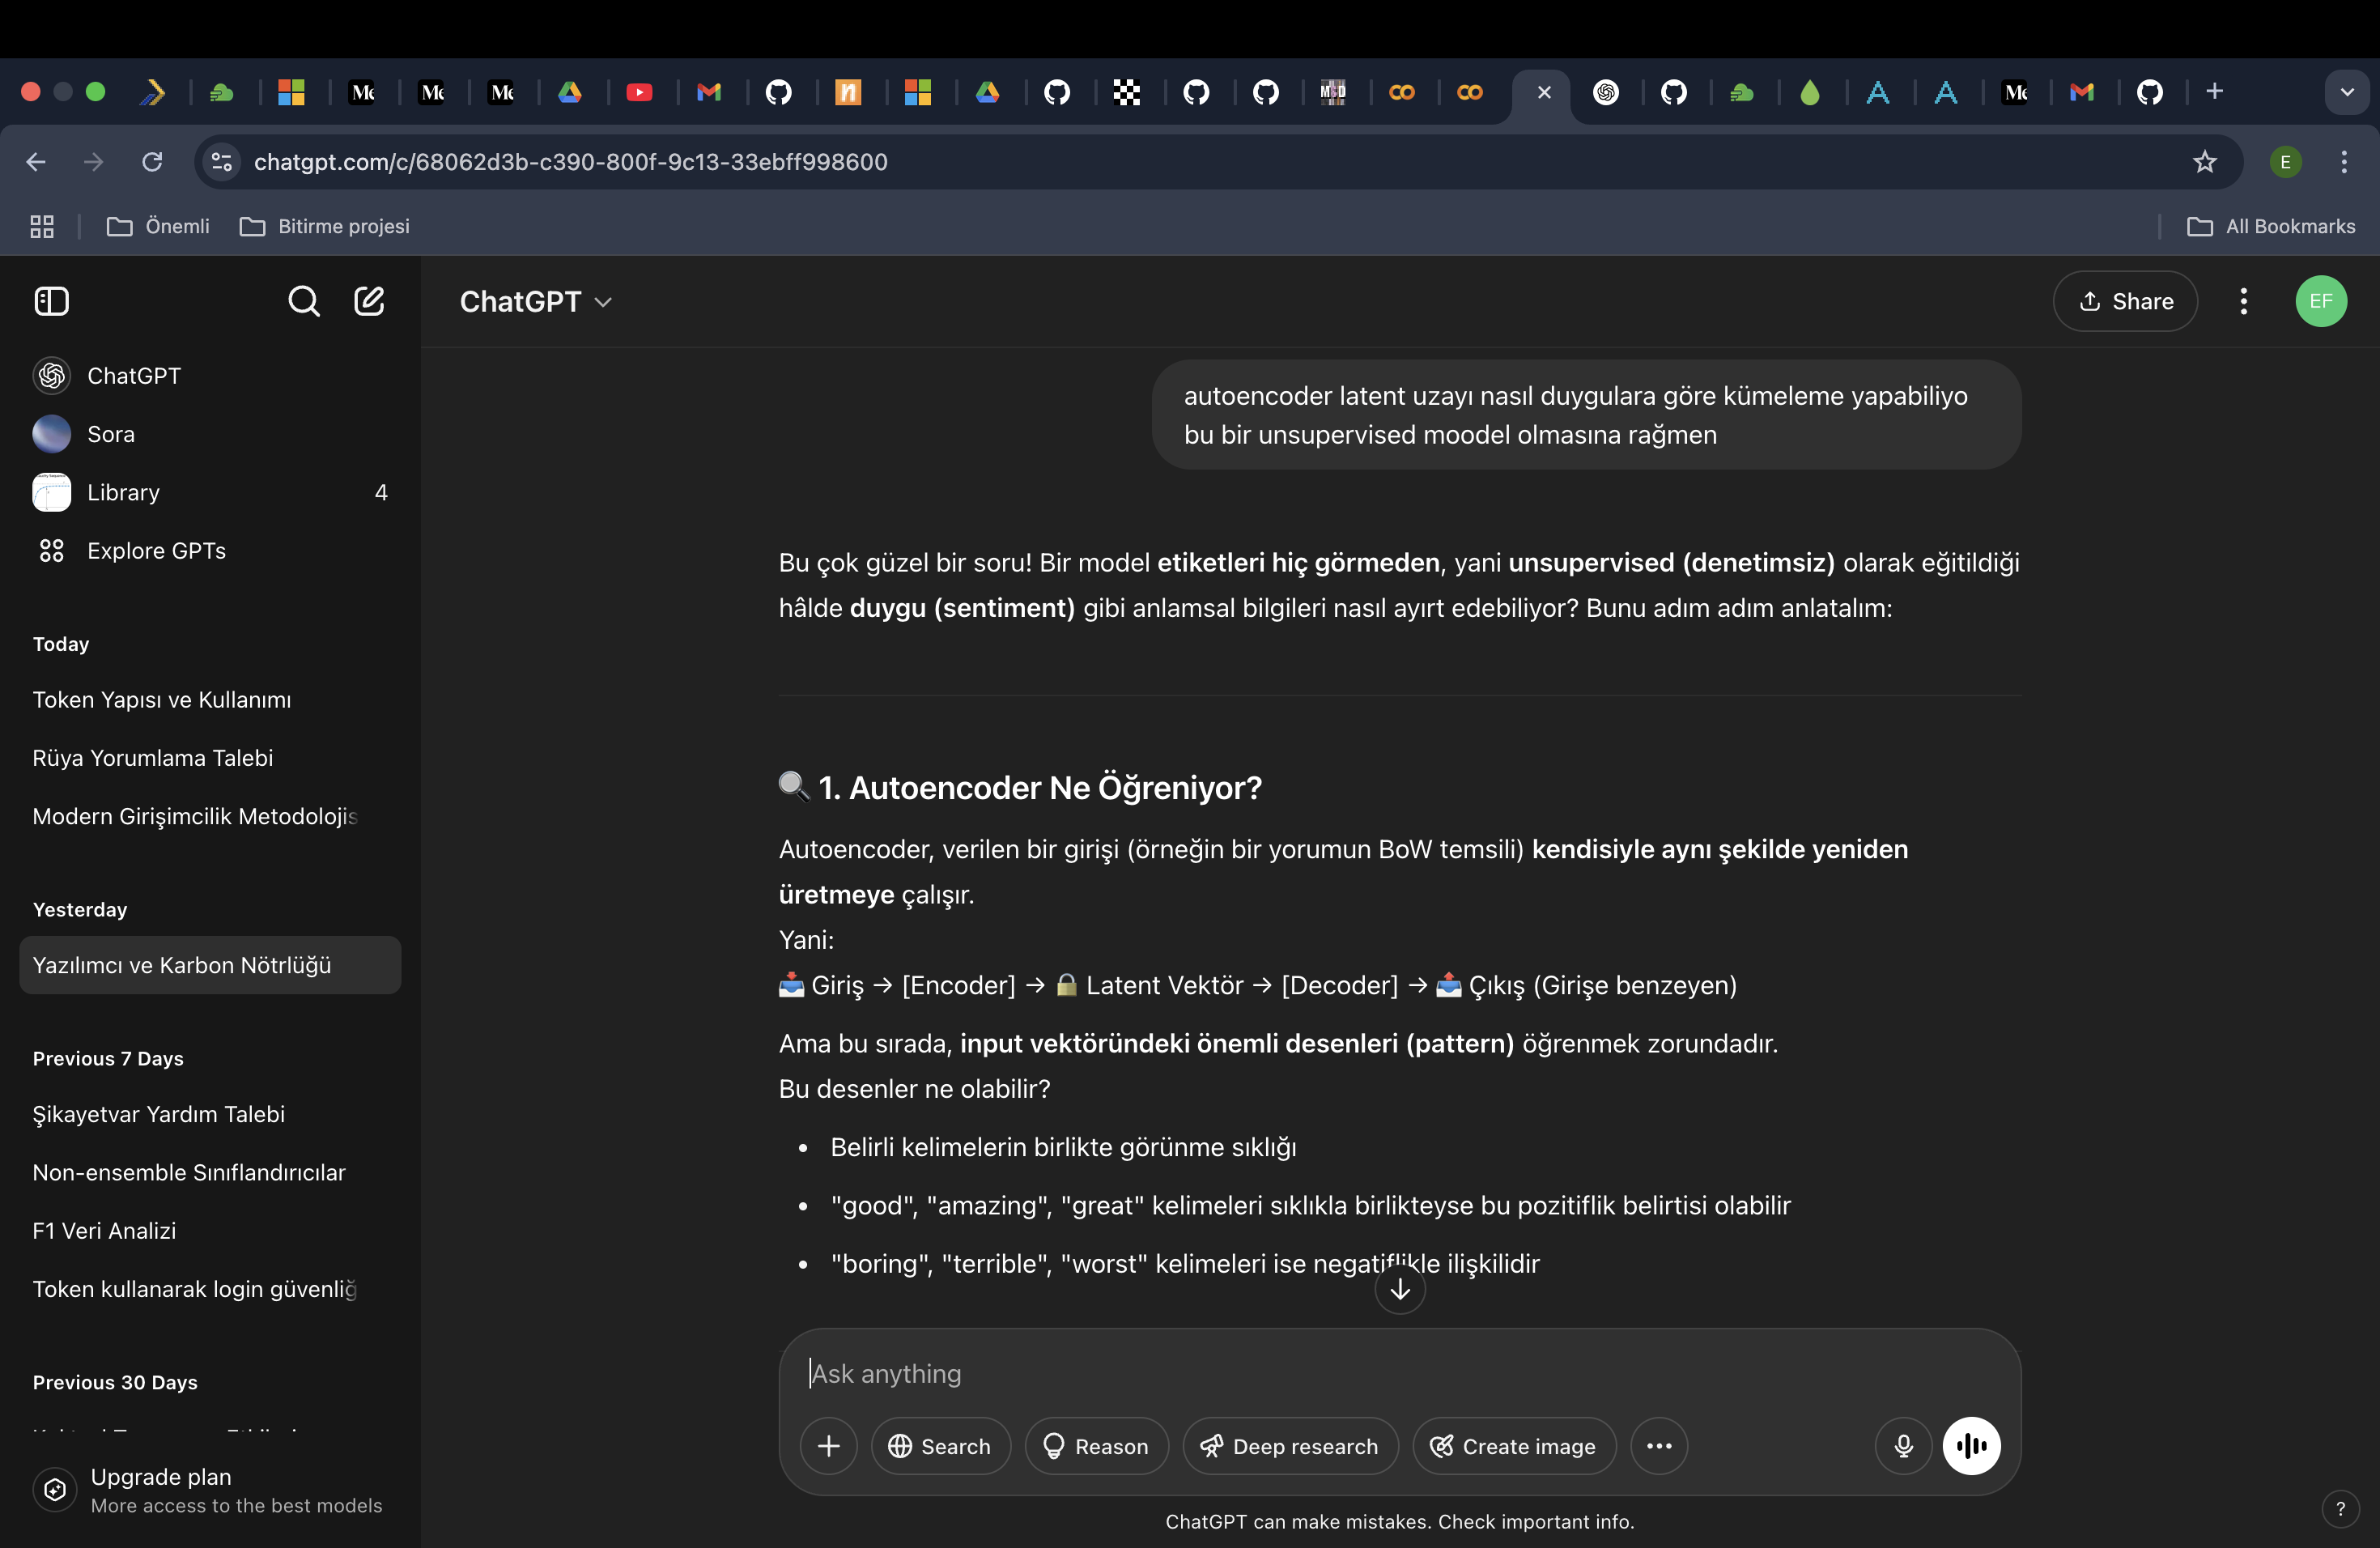